# Notebook Context

For context this is 4 of 6 Jupyter Notebooks associated with the used car project

In [21]:
# Import packages 

import pandas as pd
import glob
import numpy as np
import re
import regex
import time
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import requests
import cloudscraper
from bs4 import BeautifulSoup
import urllib.parse
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import and clean cars

The scraped cars will be cleaned in four different batches.

* Used cars - not electric
    * Starting with 374854 cars and ending with 373914
* Used cars - electric
    * Starting with 4887 cars and ending with 4740
* New cars - not electric
    * Starting with 18906 cars and ending with 18890
* New cars - electric
    * Starting with 2816 cars and ending with 2764

The cleaning method is very similar for each batch, with differences occurring in the way engine size is handled for electric/non-electric vehicles. 

I have heavily commented the code for the *Used cars - not electric* cleaning section with a slightly liter code commenting approach on the subsequent 3 batches as the method is very repetitive. If ever the approach is unclear, I would suggest checking the corresponding cleaning stage in the *Used cars - not electric* section.

## Used cars - not electric

In [40]:
# Import all detailed files and make cars df, including year 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed'

li=[]

# For each year between 1990 and 2021, import each used car file with glob package
for year in range(1990,2022):
    year_files = glob.glob(path + f"/*{year}*used.csv")
    for filename in year_files:
        # Make it into a dataframe
        df = pd.read_csv(filename, index_col=None, header=0 )
        # Assign YR variable - this was only possible because of the way in which they were gathered
        df['YR'] = year
        # Drop diplicates within a file - highly possible because of the AutoTrader searching method implemented
        df.drop_duplicates(subset=['link'], keep='first', inplace=True)
        # Append to a list of dataframes
        li.append(df)

# Concatenate all dataframes and drop duplicates again
ucars = pd.concat(li, axis=0, ignore_index=True)
ucars.drop_duplicates(subset=['link'], keep='first', inplace=True)
print('DataFrame shape:',ucars.shape)

DataFrame shape: (374854, 20)


In [41]:
# Clean cars.body 

# This block of code uses label encoder to transform the body variable, then imputs the missing body data
# with the modal value for the specified car name. 

# In hindsight there may be a better way to do this without using label encoder but it isn't broken so I won't
# try to fix it here. 

#Create df of cars will null body
nabody = ucars[ucars['body'].isnull()].copy()

#Encode body column but don't overwrite
to_encode = ['body']
cars_e = ucars.copy()
for col in to_encode:
    le = LabelEncoder()
    cars_e[col] = le.fit_transform(cars_e[col]) 

#Iterate through null-body cars and replace with corresponding modal body value based on name column grouping
for index, car in nabody.iterrows():
    carname=nabody.loc[index,'name']
    body=nabody.loc[index,'body']
    nabody.loc[index,'body'] = cars_e[cars_e['name']==carname].body.mode()[0]
    cars_e.loc[index,'body'] = cars_e[cars_e['name']==carname].body.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ucars[col] = le.inverse_transform(cars_e[col]) 

#After checking the remaining cars without a body, it is clear that they are all vans!    
ucars.body = ['Van' if pd.Series(x).isnull()[0]==True else x for x in ucars.body]        

print('DataFrame shape:',ucars.shape)

DataFrame shape: (374854, 20)


In [42]:
# Clean cars.BHP, taking values from cars.engine where necessary. Drop remaining 264 NaN. 

# Unmerge some of the BHP entries which have engine size in there too.
for index, car in ucars[ucars['BHP'].str.contains('L', regex=True, na=False)].iterrows():
    ucars.loc[index, 'engine'] = str(ucars.loc[index, 'BHP']).split(' ')[0]
    ucars.loc[index, 'BHP'] = str(ucars.loc[index, 'BHP']).split(' ')[1].strip('()') 

# Drop NaN BHP - this is only 264 cars
ucars.dropna(subset=['BHP'],inplace=True)

# This function is necessary because some BHP stats were reported in terms of PS, the German (almost) equivalent.
# It does what it says on the tin - standardises BHP stats to be in units of BHP.
def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
ucars.BHP = ucars.BHP.apply(lambda x: standardise_bhp(x))

print('DataFrame shape:',ucars.shape)

DataFrame shape: (374590, 20)


In [43]:
# Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN. 

# Split href0 into city and area
ucars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in ucars.href0]
ucars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in ucars.href0]

# There are some seller ratings in seller0, move them to seller1
# This line causes a warning. In the end I don't even use the seller ratings in the model so
# I have left this alone. It could even be commented out with no impact on the project.
ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

# Make seller ratings in seller0 np.nan
ucars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in ucars.seller0]

# If the seller0 column is np.nan, use the dealer_city 
for index, car in ucars.iterrows():
    if pd.isnull(ucars.loc[index,'seller0']):
        ucars.loc[index,'seller0']=ucars.loc[index,'dealer_city_temp']
        
# Define dealer_city column and drop surplus data
ucars['dealer_city'] = ucars['seller0']
ucars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

print('DataFrame shape:',ucars.shape)

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_25088/602657102.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0
/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_25088/602657102.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ucars[ucars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0


DataFrame shape: (374590, 21)


In [44]:
# Iterate over missing engine rows and use RegEx on name_subtitle to extract engine size where possible. 

# As mentioned above, if the engine data is null, try to recover it from the name_subtitle with RegEx
for index, car in ucars[ucars['engine'].isnull()].iterrows():
    car_subname = ucars.loc[index, 'name_subtitle']
    try:
        enginesize = re.findall('([0-9][.][0-9]+)',car_subname)[0]
    except: 
        enginesize = np.nan
    ucars.loc[index,'engine'] = float(enginesize)

# Remove L from each engine size.
ucars.engine= ucars.engine.apply(lambda x: float(str(x).replace('L','')))

# Drop remaining 105 used cars without engine size.
ucars.dropna(subset=['engine'],inplace=True)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (374485, 21)


In [45]:
# Make cars.doors 

# Function to pull the number of doors out of the name_subtitle column.
# Strucutre of the door information was studied and captured in these four RegEx expressions.
def extract_drs(x):
    drs = re.findall('( [1-8]d[Rr]?)',x, re.I)
    if len(drs) > 0:
        drs = str(drs[0]).lower()
    else:
        drs = re.findall('([1-8][ ]?door)',x, re.I)
        if len(drs) > 0:
            drs = str(drs[0])[0]+'dr'
        else:
            drs = re.findall('([1-8]dr)',x, re.I)
            if len(drs) > 0:
                drs = str(drs[0])[0]+'dr'
            else:
                drs = re.findall('(D-4D)',x, re.I)
                if len(drs) > 0:
                    drs = '4dr'
                else:
                    drs='0dr'
                
    if ('r' or 'R') not in drs:
        drs = drs.replace('d','dr')
    return drs.strip()

# Apply the extract_drs function to name_subtitle
ucars['doors'] = ucars.name_subtitle.apply(lambda x: extract_drs(x))

# Now I pursue the same logice as with car body, replacing the 0drs cars number of doors with the modal value
# for that specific name of car.

#Create df of cars with 0 doors
zerodoors = ucars[ucars['doors']=='0dr'].copy()

#Encode doors column but don't overwrite
to_encode = ['doors']
cars_e = ucars.copy()
for col in to_encode:
    le = LabelEncoder()
    cars_e[col] = le.fit_transform(cars_e[col]) 

#Iterate through zero door cars and replace with corresponding num doors based on name column grouping
for index, car in zerodoors.iterrows():
    carname=zerodoors.loc[index,'name']
    cars_e.loc[index,'doors'] = cars_e[cars_e['name']==carname].doors.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ucars[col] = le.inverse_transform(cars_e[col]) 

#Drop the remaining 254 cars without door information    
ucars=ucars[ucars.doors!='0dr'].copy()
ucars.dropna(subset=['doors'],inplace=True)
    
print('DataFrame shape:',ucars.shape)

DataFrame shape: (374231, 22)


In [46]:
# Clean cars.mileage 

#Drop the NaN values - only 295 so I'm not overly worried
ucars.dropna(subset=['mileage'],inplace=True)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373936, 22)


In [47]:
# Clean cars.fuel 

#Drop the NaN values - only 20 so I'm not overly worried
ucars.dropna(subset=['fuel'],inplace=True)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 22)


In [48]:
# Clean cars.price, make cars.ID, clean cars.year 

to_dummy=['drivetrain','make','body','transmission','fuel']

ucars.price=ucars.price.apply(lambda x: x.replace('£',''))
ucars.price=ucars.price.apply(lambda x: float(x.replace(',','')))
ucars['id'] =[x.split('/')[-1] for x in ucars.link]
ucars['year_reg']=ucars.year
ucars['year']=ucars.YR
ucars.drop('YR',inplace=True, axis=1)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 23)


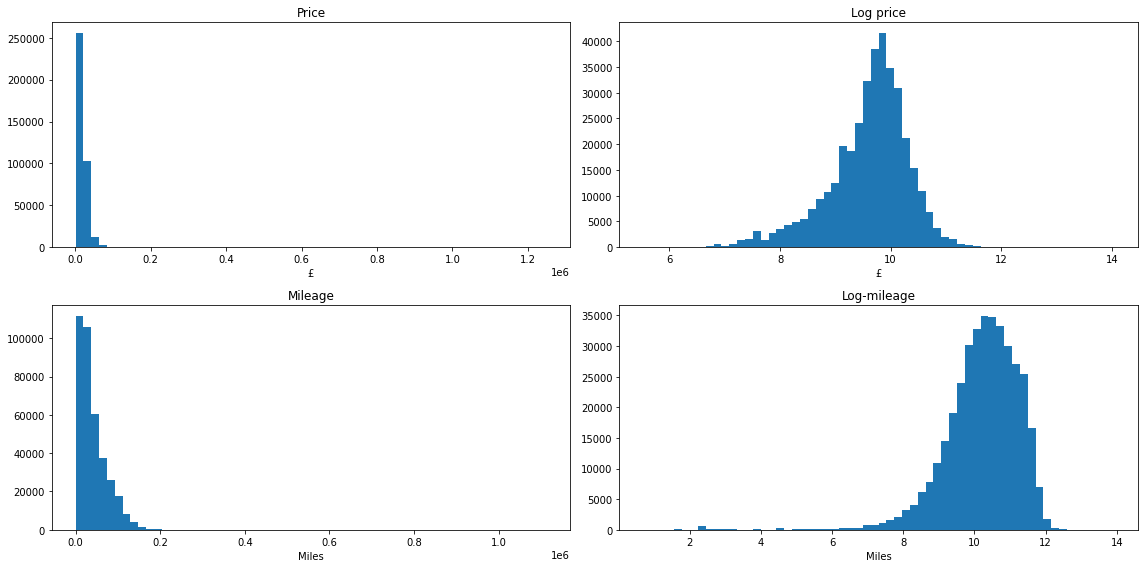

In [49]:
# Have a peek at the price and mileage distribution. 

# This is really just a quick look. No outliers have been dropped.
# You'll notice that I make a log-transofrm of the price and mileage data when obbserving the
# distributions - this will be discussed later.

ucars['log_price']=ucars.price.apply(lambda x: np.log(x))
ucars['log_mileage']=ucars.mileage.apply(lambda x: np.log(x))

# Logic to drop some outliers if wanted

#mask = np.abs((ucars.price - ucars.price.mean(0)) / ucars.price.std(0)) > 3
#ucars= ucars[~mask]
#ucars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');
#mask = np.abs((ucars.mileage - ucars.mileage.mean(0)) / ucars.mileage.std(0)) > 3
#ucars= ucars[~mask]
#ucars.mileage.plot(kind='hist', bins=50, title='Car Mileage');

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
ax[0,0].hist(ucars.price, bins=60)
ax[0,1].hist(ucars.log_price, bins=60)
ax[1,0].hist(ucars.mileage, bins=60)
ax[1,1].hist(ucars.log_mileage, bins=60)
ax[0,0].set_xlabel('£')
ax[0,1].set_xlabel('£')
ax[1,0].set_xlabel('Miles')
ax[1,1].set_xlabel('Miles')
ax[0,0].set_title('Price')
ax[0,1].set_title('Log price')
ax[1,0].set_title('Mileage')
ax[1,1].set_title('Log-mileage')
plt.tight_layout()
plt.show()

In [50]:
# Simplify the cars.name column. Probably not perfect.

# Save off the original name as on car listing
ucars['orig_name'] = ucars.name
ucars['lname']=ucars.name.apply(lambda x: x.lower())

# Lists of potential car bodies and names from Carsized.com, see associated notebook.
body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
       "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']

# The aim is to standardise the car.name column a little in terms. I was just curious to see if this would work
# and it will come in useful for the further work when I try to merge carsized.com data with autotrader data.

results = []
# Iterate over all cars, extracting the lowercase name
for index, car in ucars.iterrows():
    lname = car[-1]
    # Set dummy variable to lowercase car name
    dummy = lname
    
    # Check if the lowercase name matches any in the name_list_from_carsized
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    
    # Iterate over bodies in body
    for bod in body:
        if bod in dummy:
            # Remove body information from the carname saved under dummy variable
            dummy = re.sub(' '+bod,'',dummy)
    
    # Append car name to results
    results.append(dummy)

# Overwrite name with this new carsized standardised name and drop the lname variable.
ucars['name']=results
ucars=ucars.drop('lname', axis=1)

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 26)


In [51]:
# Add cars.used and cars.e_engine_kWh columns to be compatible with other datasets 

ucars['used']=1
ucars['e_engine_kWh']= np.nan

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373916, 28)


In [146]:
# Removing some data enrty errors which have been identified by EDA later in the project.

#Remove SKODA 911 which stands as an aggressive outlier - data entry error
ucars[ucars.make=='SKODA'].sort_values(by='price',ascending=False).head(1)
dropindex = ucars[ucars.make=='SKODA'].sort_values(by='price',ascending=False).head(1).index.tolist()
ucars.drop(index=dropindex, inplace=True)

# Remove Mercedes missing a decimal which stands as an aggressive outlier - data entry error
ucars[ucars.make=='Mercedes-Benz'].sort_values(by='price',ascending=False).head(1)
dropindex = ucars[ucars.make=='Mercedes-Benz'].sort_values(by='price',ascending=False).head(1).index.tolist()
ucars.drop(index=dropindex, inplace=True)

# Remove two clear BHP errors which stand as an aggressive outlier - data entry error
ucars.BHP.sort_values(by='BHP',ascending=False).head(2)
dropindex = ucars.BHP.sort_values(ascending=False).head(2).index.tolist()
ucars.drop(index=dropindex, inplace=True)

print('DataFrame shape:',ucars.shape)

[171470, 227650]

In [53]:
# Output clean used cars data 
ucars=ucars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
ucars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_cars.csv'
ucars.to_csv(ucars_abspath, index=False, header=ucars.columns )

print('DataFrame shape:',ucars.shape)

DataFrame shape: (373914, 28)


In [54]:
ucars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373914 entries, 0 to 594731
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           373914 non-null  object 
 1   name_subtitle  373914 non-null  object 
 2   year           373914 non-null  int64  
 3   price          373914 non-null  float64
 4   body           373914 non-null  object 
 5   mileage        373914 non-null  float64
 6   BHP            373914 non-null  float64
 7   doors          373914 non-null  object 
 8   transmission   373914 non-null  object 
 9   make           373914 non-null  object 
 10  fuel           373914 non-null  object 
 11  mpg            373914 non-null  object 
 12  drivertrain    373914 non-null  object 
 13  engine         373914 non-null  float64
 14  owners         191966 non-null  float64
 15  ULEZ           325817 non-null  object 
 16  dealer_area    318102 non-null  object 
 17  dealer_city    373642 non-nul

Note that not all of these variables are fully populated for all cars. This is not the list of variable to go into modelling, only the list of variables after cleaning.

In [55]:
ucars.describe()

,year,price,mileage,BHP,engine,owners,seller1,used,e_engine_kWh,log_price,log_mileage
count,373914.000000,3.739140e+05,3.739140e+05,373914.000000,373914.000000,191966.000000,307186.000000,373914.0,0.0,373914.000000,373914.000000
mean,2016.316287,1.839087e+04,4.037487e+04,155.396927,1.745712,1.865575,4.639705,1.0,NaN,9.602695,10.209385
std,3.514845,1.240514e+04,3.293627e+04,67.819654,0.557112,1.139197,0.441332,0.0,NaN,0.718111,1.077989
min,1994.000000,2.500000e+02,2.000000e+00,1.000000,0.600000,1.000000,1.000000,1.0,NaN,5.521461,0.693147
25%,2015.000000,1.049100e+04,1.600000e+04,113.000000,1.400000,1.000000,4.500000,1.0,NaN,9.258273,9.680344
50%,2017.000000,1.669000e+04,3.059200e+04,138.067061,1.600000,2.000000,4.700000,1.0,NaN,9.722565,10.328494
75%,2019.000000,2.349500e+04,5.660000e+04,187.376726,2.000000,2.000000,4.900000,1.0,NaN,10.064543,10.943764
max,2021.000000,1.250000e+06,1.113000e+06,1998.000000,5.500000,26.000000,5.000000,1.0,NaN,14.038654,13.922570


In [133]:
ucars.BHP.sort_values(ascending=False).head(20)

171470    1998.000000
227650    1498.000000
578761     972.386588
578769     972.386588
578767     972.386588
578766     972.386588
578765     972.386588
578764     972.386588
578763     972.386588
578762     972.386588
578760     972.386588
578759     972.386588
578758     972.386588
578757     972.386588
578770     972.386588
578771     972.386588
578772     972.386588
550859     972.386588
578768     972.386588
99410      727.000000
Name: BHP, dtype: float64

In [142]:
print(ucars.loc[227650,:])

name                                                 ford ecosport
name_subtitle                               1.5 TDCi Zetec 2WD 5dr
year                                                          2017
price                                                      10995.0
body                                                           SUV
mileage                                                    46000.0
BHP                                                         1498.0
doors                                                          5dr
transmission                                                Manual
make                                                          Ford
fuel                                                        Diesel
mpg                                                        OVER_60
drivertrain                                      Front Wheel Drive
engine                                                         1.5
owners                                                        

In [57]:
ucars.sample(5)

,name,name_subtitle,year,price,body,mileage,BHP,doors,transmission,make,...,seller1,used,e_engine_kWh,log_price,log_mileage,orig_name,id,year_reg,link,href0
202895,lexus gs,300h 2.5 Executive Edition 4dr CVT,2017,23450.0,Saloon,45170.0,219.921105,4dr,Automatic,Lexus,...,4.7,1,NaN,10.062626,10.718188,Lexus GS Saloon,202111239872724,2017 (67 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/yorkshire/sheffield/lexus-sheffield-9...
193670,hyundai tucson,Hyundai Tucson 1.7 CRDi Blue Drive SE Nav 5dr 2WD,2017,15599.0,SUV,49585.0,114.398422,5dr,Manual,Hyundai,...,4.9,1,NaN,9.654962,10.811444,Hyundai Tucson,202110278928408,2017 (17 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/staffordshire/cannock/available-car-s...
433879,toyota hilux,Invincible X Ltd Ed D/Cab P/Up 2.4 D-4D Auto 3.5t,2018,33990.0,Pickup,18405.0,147.928994,4dr,Automatic,Toyota,...,4.6,1,NaN,10.433822,9.820378,Toyota Hilux Special Editions,202201191536515,2018 (68 reg),https://www.autotrader.co.uk/car-details/20220...,/dealers/lancashire/preston/evans-halshaw-ford...
6039,mercedes-benz m class,3.0 ML320 CDI SE 7G-Tronic 5dr,2006,4995.0,SUV,107625.0,221.000000,5dr,Automatic,Mercedes-Benz,...,4.3,1,NaN,8.516193,11.586408,Mercedes-Benz M Class,202112200673073,2006 (06 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/west-midlands/dudley/msh-motors-ltd-1...
77149,mercedes-benz e-class,2.1 E250 CDI AMG LINE 2d 201 BHP,2014,14495.0,Coupe,54000.0,201.000000,2dr,Automatic,Mercedes-Benz,...,4.6,1,NaN,9.581559,10.896739,Mercedes-Benz E-Class,202112060279047,2014 (64 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/west-midlands/solihull/motorserv-uk-c...


## Used cars - electric

In [59]:
# Import all detailed files and make cars df, including year 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed_ev/'

li=[]
year_files = glob.glob(path + f"/*electric_used.csv")
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

uecars = pd.concat(li, axis=0, ignore_index=True)
uecars.drop_duplicates(subset=['link'], keep='first', inplace=True)
uecars.shape    

(4887, 20)

In [60]:
uecars.body.isnull().sum()

0

In [61]:
# Body is fine. No cleaning needed.
uecars.body.isnull().sum()

uecars.shape

(4887, 20)

In [62]:
# Clean BHP.

# Drop NaN BHP
uecars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
uecars.BHP = uecars.BHP.apply(lambda x: standardise_bhp(x))

uecars.shape

(4823, 20)

In [63]:
# Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
uecars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in uecars.href0]
uecars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in uecars.href0]

#If there are some seller ratings in seller0, move them to seller1
uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
uecars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in uecars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in uecars.iterrows():
    if pd.isnull(uecars.loc[index,'seller0']):
        uecars.loc[index,'seller0']=uecars.loc[index,'dealer_city_temp']
    #Tiny number of cars don't have a location, and they're all from one dealer in Oldbury.    
    if pd.isnull(uecars.loc[index,'seller0']):
        uecars.loc[index,'seller0']= 'Oldbury'
        
uecars['dealer_city'] = uecars['seller0']
uecars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

uecars.shape

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_25088/350232228.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0
/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_25088/350232228.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = uecars[uecars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0


(4823, 21)

In [64]:
# Populate uecars.e_engine_kWh from name_subtitle ~20% NaN. Not great but BHP supersedes it.

# For electric cars we can't measure engline volume in litres. This is a pain but not too problematic
# because fortunately BHP supersedes it. This won't be used in modelling. 
uecars['e_engine_kWh']=''
uecars['engine']=np.nan

for index, car in uecars.iterrows():
    car_subname = uecars.loc[index, 'name_subtitle']
    try:
        eenginesize = re.findall('[\d]+[.]?[\d]+[ ]?kwh',car_subname, flags=re.I)[0]
    except: 
        eenginesize = np.nan
    uecars.loc[index,'e_engine_kWh'] = eenginesize
    
uecars.e_engine_kWh= uecars.e_engine_kWh.apply(lambda x: float(str(x).lower().replace('kwh','')))
#uecars.dropna(subset=['engine'],inplace=True)

uecars.shape

(4823, 22)

In [65]:
# Make doors column. Drop 53 without info. 
     
uecars['doors'] = uecars.name_subtitle.apply(lambda x: extract_drs(x))

# Drop the remaining 53 uecars without door information    
uecars.drop(uecars[uecars.doors=='0dr'].index, inplace=True)

uecars.shape

(4770, 23)

In [66]:
# Clean uecars.price, make uecars.ID, clean uecars.year. Fix uecars.ULEZ 
to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

uecars.price=uecars.price.apply(lambda x: x.replace('£',''))
uecars.price=uecars.price.apply(lambda x: float(x.replace(',','')))
uecars['id'] =[x.split('/')[-1] for x in uecars.link]
uecars['year_reg']=uecars['year']
uecars['year']=uecars['YR']
uecars.drop('YR',inplace=True, axis=1)
uecars.owners=int(0)
uecars.ULEZ='ULEZ'


uecars.shape

(4770, 24)

In [67]:
# Set uecars.used = 1.

uecars['used']=1


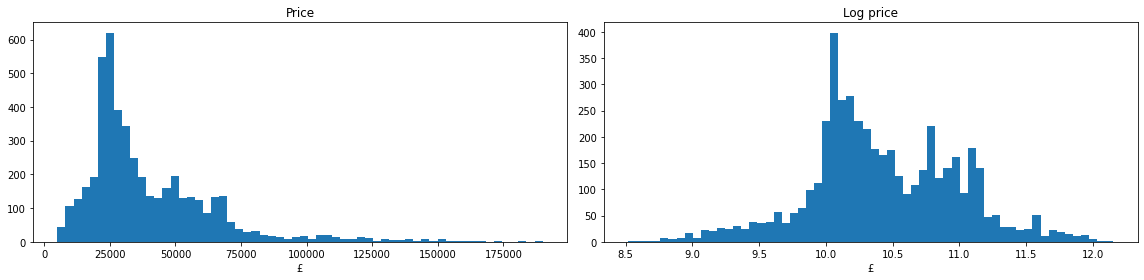

In [68]:
# Have a peek at the price and mileage distribution

uecars.drop(uecars[uecars.mileage.isnull()].index, inplace=True)
uecars['log_price']=uecars.price.apply(lambda x: np.log(x))
uecars['mileage']=uecars.mileage.apply(lambda x: float(x))
uecars['log_mileage']=uecars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(uecars.price, bins=60)
ax[1].hist(uecars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [69]:
# Simplify the name column a little. Probably not perfect 

uecars['orig_name'] = uecars.name
uecars['lname']=uecars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
        "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']

results = []
for index, car in uecars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)

uecars['name']=results
uecars=uecars.drop('lname', axis=1)

uecars.shape

(4740, 28)

In [70]:
# Output clean used cars data 
uecars=uecars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
uecars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_used_electric_cars.csv'
uecars.to_csv(uecars_abspath, index=False, header=uecars.columns )

In [71]:
uecars.mpg.value_counts()

Electric    4740
Name: mpg, dtype: int64

In [72]:
uecars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4740 entries, 0 to 4886
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4740 non-null   object 
 1   name_subtitle  4740 non-null   object 
 2   year           4740 non-null   int64  
 3   price          4740 non-null   float64
 4   body           4740 non-null   object 
 5   mileage        4740 non-null   float64
 6   BHP            4740 non-null   float64
 7   doors          4740 non-null   object 
 8   transmission   4740 non-null   object 
 9   make           4740 non-null   object 
 10  fuel           4740 non-null   object 
 11  mpg            4740 non-null   object 
 12  drivertrain    4740 non-null   object 
 13  engine         0 non-null      float64
 14  owners         4740 non-null   int64  
 15  ULEZ           4740 non-null   object 
 16  dealer_area    3880 non-null   object 
 17  dealer_city    4740 non-null   object 
 18  seller1 

## New cars - not electric

In [73]:
# Import all detailed files and make new ncars df, including year

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed/'

li=[]
year_files = glob.glob(path + f"/*2023_new.csv")
#print(len(year_files),'file(s) to load from', year)
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df['YR'] = '2022 new'
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

ncars = pd.concat(li, axis=0, ignore_index=True)
ncars.drop_duplicates(subset=['link'], keep='first', inplace=True)
ncars.shape  

(18906, 20)

In [74]:
#Clean ncars.body

#Create df of ncars will null body
nabody = ncars[ncars['body'].isnull()].copy()

#Encode body column but don't overwrite
to_encode = ['body']
ncars_e = ncars.copy()
for col in to_encode:
    le = LabelEncoder()
    ncars_e[col] = le.fit_transform(ncars_e[col]) 

#Iterate through null-body ncars and replace with corresponding modal body value based on name column grouping
for index, car in nabody.iterrows():
    carname=nabody.loc[index,'name']
    body=nabody.loc[index,'body']
    nabody.loc[index,'body'] = ncars_e[ncars_e['name']==carname].body.mode()[0]
    ncars_e.loc[index,'body'] = ncars_e[ncars_e['name']==carname].body.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ncars[col] = le.inverse_transform(ncars_e[col]) 

#After checking the remaining ncars without a body, it is clear that they are all vans!    
ncars.body = ['Van' if pd.Series(x).isnull()[0]==True else x for x in ncars.body]        

ncars.shape

(18906, 20)

In [75]:
#Clean ncars.BHP, taking values from ncars.engine where necessary. Drop remaining NaN.

# Unmerge some of the BHP entries which have engine size in there too.
for index, car in ncars[ncars['BHP'].str.contains('L', regex=True, na=False)].iterrows():
    ncars.loc[index, 'engine'] = str(ncars.loc[index, 'BHP']).split(' ')[0]
    ncars.loc[index, 'BHP'] = str(ncars.loc[index, 'BHP']).split(' ')[1].strip('()') 

# Drop NaN BHP
ncars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
ncars.BHP = ncars.BHP.apply(lambda x: standardise_bhp(x))

ncars.shape

(18890, 20)

In [76]:
#Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
ncars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in ncars.href0]
ncars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in ncars.href0]

#If there are some seller ratings in seller0, move them to seller1
ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
ncars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in ncars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in ncars.iterrows():
    if pd.isnull(ncars.loc[index,'seller0']):
        ncars.loc[index,'seller0']=ncars.loc[index,'dealer_city_temp']
        
ncars['dealer_city'] = ncars['seller0']
ncars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

ncars.shape

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_25088/1268207855.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = ncars[ncars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0


(18890, 21)

In [77]:
# Iterate over missing engine rows and use regex name_subtitle to extract engine size where possible. Convert to float

for index, car in ncars[ncars['engine'].isnull()].iterrows():
    car_subname = ncars.loc[index, 'name_subtitle']
    try:
        enginesize = re.findall('([0-9][.][0-9]+)',car_subname)[0]
    except: 
        enginesize = np.nan
    ncars.loc[index,'engine'] = float(enginesize)
    
ncars.engine= ncars.engine.apply(lambda x: float(str(x).replace('L','')))
ncars.dropna(subset=['engine'],inplace=True)

ncars.shape

(18890, 21)

In [78]:
# Make doors column

def extract_drs(x):
    drs = re.findall('( [1-8]d[Rr]?)',x, re.I)
    if len(drs) > 0:
        drs = str(drs[0]).lower()
    else:
        drs = re.findall('([1-8][ ]?door)',x, re.I)
        if len(drs) > 0:
            drs = str(drs[0])[0]+'dr'
        else:
            drs = re.findall('([1-8]dr)',x, re.I)
            if len(drs) > 0:
                drs = str(drs[0])[0]+'dr'
            else:
                drs = re.findall('(D-4D)',x, re.I)
                if len(drs) > 0:
                    drs = '4dr'
                else:
                    drs='0dr'
                
    if ('r' or 'R') not in drs:
        drs = drs.replace('d','dr')
    return drs.strip()
     
ncars['doors'] = ncars.name_subtitle.apply(lambda x: extract_drs(x))

#Create df of ncars with 0 doors
zerodoors = ncars[ncars['doors']=='0dr'].copy()

#Encode doors column but don't overwrite
to_encode = ['doors']
ncars_e = ncars.copy()
for col in to_encode:
    le = LabelEncoder()
    ncars_e[col] = le.fit_transform(ncars_e[col]) 

#Iterate through zero door ncars and replace with corresponding num doors based on name column grouping
for index, car in zerodoors.iterrows():
    carname=zerodoors.loc[index,'name']
    ncars_e.loc[index,'doors'] = ncars_e[ncars_e['name']==carname].doors.mode()[0]     

#Reverse the encoding    
for col in to_encode:
    ncars[col] = le.inverse_transform(ncars_e[col]) 

#Drop the remaining 226 ncars without door information    
ncars.dropna(subset=['doors'],inplace=True)
    
ncars.shape

(18890, 22)

In [79]:
# Clean ncars.mileage

#Drop them - only 283
ncars.mileage = '0'

ncars.shape

(18890, 22)

In [80]:
# Clean ncars.fuel

#Drop them - only 12
ncars.dropna(subset=['fuel'],inplace=True)

ncars.shape

(18890, 22)

In [81]:
# Clean ncars.price, make ncars.ID, clean ncars.year 

to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

ncars.price=ncars.price.apply(lambda x: x.replace('£',''))
ncars.price=ncars.price.apply(lambda x: float(x.replace(',','')))
ncars['id'] =[x.split('/')[-1] for x in ncars.link]
ncars['year_reg']=ncars.year
ncars['year']= 2022
ncars.drop('YR',inplace=True, axis=1)

ncars.shape

(18890, 23)

In [82]:
#Obtain ncars.ll_search <-- Doesn't actually work with nominatim openstreetmap. Probably not needed.

# ncars['ll_search']=''
# ll_search_series = []
# for index, car in tqdm(ncars.iterrows()):
#     dc = str(car[19])
#     da = str(car[18])
#     if dc == 'nan':
#         dc = ''
#     if da == 'nan':
#         da = ''
#     car[23] = dc+' '+da
#     ll_search_series.append(car[23])
# ncars['ll_search'] = ll_search_series


In [83]:
#Iterate over ncars to convert dealer_city to lat/lon. 2s per car makes this a 2+day cell. Running in other workbook. 

# lat_series = []
# lon_series = []

# for index, car in tqdm(ncars.iterrows()):
#     address = car[19] + ' UK'
#     url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
#     response = requests.get(url).json()
#     lat_series.append(response[0]["lat"])
#     lon_series.append(response[0]["lon"])
    
# ncars['seller_lat']=lat_series
# ncars['seller_lon']=lon_series
    

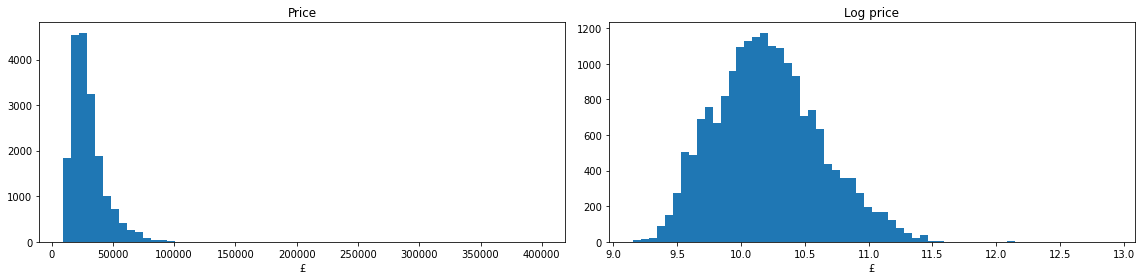

In [84]:
# Have a peek at the price and mileage distribution

ncars['log_price']=ncars.price.apply(lambda x: np.log(x))
ncars['mileage']=ncars.mileage.apply(lambda x: float(x))
ncars['log_mileage']=ncars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(ncars.price, bins=60)
ax[1].hist(ncars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [85]:
# Simplify the name column a little. Probably not perfect 

ncars['orig_name'] = ncars.name
ncars['lname']=ncars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
       "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']

results = []
for index, car in ncars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)
results

ncars['name']=results
ncars=ncars.drop('lname', axis=1)

ncars.shape

(18890, 26)

In [86]:
# Add ncars.used and ncars.e_engine_kWh columns to be compatible with other datasets 

ncars['used']=0
ncars['e_engine_kWh']= np.nan

ncars.shape

(18890, 28)

In [87]:
# Output clean used cars data 
ncars=ncars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
ncars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_cars.csv'
ncars.to_csv(ncars_abspath, index=False, header=ncars.columns )

In [88]:
ncars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18890 entries, 0 to 50386
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           18890 non-null  object 
 1   name_subtitle  18890 non-null  object 
 2   year           18890 non-null  int64  
 3   price          18890 non-null  float64
 4   body           18890 non-null  object 
 5   mileage        18890 non-null  float64
 6   BHP            18890 non-null  float64
 7   doors          18890 non-null  object 
 8   transmission   18890 non-null  object 
 9   make           18890 non-null  object 
 10  fuel           18890 non-null  object 
 11  mpg            18890 non-null  object 
 12  drivertrain    18890 non-null  object 
 13  engine         18890 non-null  float64
 14  owners         0 non-null      float64
 15  ULEZ           18780 non-null  object 
 16  dealer_area    16203 non-null  object 
 17  dealer_city    18686 non-null  object 
 18  seller

## New cars - electric

In [89]:
# Import all detailed files and make new ncars df, including year

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/raw/df_detailed_ev/'

li=[]
year_files = glob.glob(path + f"/*2023_electric_new.csv")
#print(len(year_files),'file(s) to load from', year)
for filename in year_files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    df['YR'] = '2022 new'
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

necars = pd.concat(li, axis=0, ignore_index=True)
necars.drop_duplicates(subset=['link'], keep='first', inplace=True)
necars.shape  

(2816, 20)

In [90]:
# Body is fine. No cleaning needed.

necars.shape

(2816, 20)

In [91]:
# Clean BHP.

# Drop NaN BHP
necars.dropna(subset=['BHP'],inplace=True)

def standardise_bhp(x):
    lenbhp = len(str(x).split(' '))
    bhp=x
    if lenbhp == 1:
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])       
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014        
    elif lenbhp == 2:
        x=str(x.split(' ')[-1])
        if 'BHP' in x:
            bhp=float(re.findall('[0-9]+', x)[0])      
        elif 'PS' in x:
            ps=float(re.findall('[0-9]+', x)[0])
            bhp = ps/1.014
    else:
        bhp=np.nan   
    return bhp    

#Standardise remaining BHP (convert from PS)
necars.BHP = necars.BHP.apply(lambda x: standardise_bhp(x))

necars.shape

(2768, 20)

In [92]:
#Compile the best location variable. Retain dealer_city and dealer_area. Don't drop remaining NaN.

#split href0 into city and area
necars['dealer_city_temp'] = [x.split('/')[3] if type(x)==str and len(x.split('/'))>3 else x for x in necars.href0]
necars['dealer_area'] = [x.split('/')[2] if type(x)==str and len(x.split('/'))>3 else x for x in necars.href0]

#If there are some seller ratings in seller0, move them to seller1
necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0

#Make seller ratings in seller0 np.nan
necars.seller0 =[np.nan if '4' in str(x) or '5' in str(x) else x for x in necars.seller0]

#If the seller0 column is np.nan, use the dealer_city 
for index, car in necars.iterrows():
    if pd.isnull(necars.loc[index,'seller0']):
        necars.loc[index,'seller0']=necars.loc[index,'dealer_city_temp']
    #Tiny number of cars don't have a location, and they're all from one dealer in Oldbury.    
    if pd.isnull(necars.loc[index,'seller0']):
        necars.loc[index,'seller0']= 'Oldbury'
        
necars['dealer_city'] = necars['seller0']
necars.drop(['seller0','dealer_city_temp'],inplace=True, axis=1)

necars.shape

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_25088/3195580599.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller1 = necars[necars['seller0'].str.contains('[+-]?([0-9]*[.])?[0-9]+', regex=True, na=False)].seller0


(2768, 21)

In [93]:
# Populate necars.e_engine_kWh from name_subtitle ~20% NaN. Not great but BHP supersedes it.

necars['e_engine_kWh']=''
necars['engine']=np.nan

for index, car in necars.iterrows():
    car_subname = necars.loc[index, 'name_subtitle']
    try:
        eenginesize = re.findall('[\d]+[.]?[\d]+[ ]?kwh',car_subname, flags=re.I)[0]
    except: 
        eenginesize = np.nan
    necars.loc[index,'e_engine_kWh'] = eenginesize
    
necars.e_engine_kWh= necars.e_engine_kWh.apply(lambda x: float(str(x).lower().replace('kwh','')))
#necars.dropna(subset=['engine'],inplace=True)

necars.shape

(2768, 22)

In [94]:
# Make doors column. Drop 4 without info. 
     
necars['doors'] = necars.name_subtitle.apply(lambda x: extract_drs(x))

# Drop the remaining 4 necars without door information    
necars.drop(necars[necars.doors=='0dr'].index, inplace=True)

necars.shape

(2764, 23)

In [95]:
# Clean necars.price, make necars.ID, clean necars.year 
to_dummy=['mpg','drivetrain','make','body','transmission','fuel']

necars.price=necars.price.apply(lambda x: x.replace('£',''))
necars.price=necars.price.apply(lambda x: float(x.replace(',','')))
necars['id'] =[x.split('/')[-1] for x in necars.link]
necars['year_reg']=necars.YR
necars['year']=2022
necars.drop('YR',inplace=True, axis=1)
necars.owners=int(0)
necars.ULEZ='ULEZ'


necars.shape

(2764, 24)

In [96]:
# Set necars.mileage = 0. Set necars.used = 0.

necars['mileage']= 0
necars['used']=0


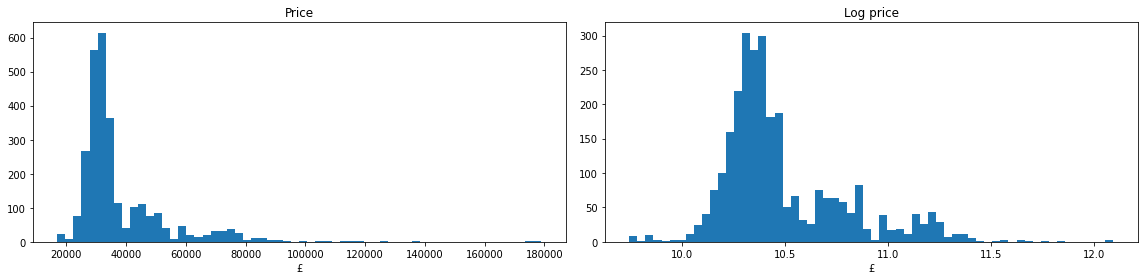

In [97]:
# Have a peek at the price and mileage distribution

necars['log_price']=necars.price.apply(lambda x: np.log(x))
necars['mileage']=necars.mileage.apply(lambda x: float(x))
necars['log_mileage']=necars.mileage.apply(lambda x: np.log(x))

#mask = np.abs((ncars.price - ncars.price.mean(0)) / ncars.price.std(0)) > 3
#ncars= ncars[~mask]
#ncars.price.plot(kind='hist', bins=50, title='Car Price after outlier removal', xlabel='£');

fig, ax = plt.subplots(ncols=2, figsize=(16,4))
ax[0].hist(necars.price, bins=60)
ax[1].hist(necars.log_price, bins=60)
ax[0].set_xlabel('£')
ax[1].set_xlabel('£')
ax[0].set_title('Price')
ax[1].set_title('Log price')
plt.tight_layout()
plt.show()

In [98]:
# Simplify the name column a little. Probably some room for improvement here but it will be used when merging 

necars['orig_name'] = necars.name
necars['lname']=necars.name.apply(lambda x: x.lower())

body =["coupe", "convertible", "estate", "hatchback", "MPV", "pickup", 
        "SUV", "saloon","cabriolet","sedan"]
name_list_from_carsized = ['abarth 500', 'acura nsx', 'alfa-romeo 147', 'alfa-romeo 156',
       'alfa-romeo 159', 'alfa-romeo 164', 'alfa-romeo 4c',
       'alfa-romeo giulia', 'alfa-romeo giulietta', 'alfa-romeo mito',
       'alfa-romeo sprint', 'alfa-romeo stelvio', 'alvis tc 108',
       'aston-martin db11', 'aston-martin dbx', 'aston-martin rapide',
       'aston-martin vantage', 'audi 100', 'audi a1', 'audi a2',
       'audi a3', 'audi a4', 'audi a5', 'audi a6', 'audi a7', 'audi a8',
       'audi e tron', 'audi e tron gt', 'audi q2', 'audi q3',
       'audi q4 e tron', 'audi q5', 'audi q7', 'audi q8', 'audi r8',
       'audi tt', 'austin 7', 'austin healey 3000', 'bentley 3 5 litre',
       'bentley bentayga', 'bentley continental flying spur',
       'bentley continental gt', 'bentley flying spur', 'bmw 1 series', 'bmw 2 series',
       'bmw 3 series', 'bmw 4 series', 'bmw 5 series', 'bmw 6 series', 'bmw 7 series', 'bmw 8 series',
       'bmw i3', 'bmw i8', 'bmw isetta', 'bmw ix', 'bmw x1', 'bmw x2',
       'bmw x3', 'bmw x4', 'bmw x5', 'bmw x6', 'bmw x7', 'bmw z4',
       'buick skylark', 'cadillac ats', 'cadillac bls', 'cadillac cts',
       'cadillac eldorado', 'cadillac escalade', 'cadillac seville',
       'cadillac srx', 'cadillac xt5', 'chevrolet aveo',
       'chevrolet bel air', 'chevrolet camaro', 'chevrolet caprice',
       'chevrolet captiva', 'chevrolet corvette', 'chevrolet cruze',
       'chevrolet epica', 'chevrolet equinox', 'chevrolet impala',
       'chevrolet malibu', 'chevrolet matiz', 'chevrolet spark',
       'chevrolet tahoe', 'chrysler 300', 'chrysler pt cruiser',
       'chrysler sebring', 'chrysler voyager', 'citroen b14',
       'citroen berlingo', 'citroen c crosser', 'citroen c elysee',
       'citroen c1', 'citroen c3', 'citroen c3 aircross', 'citroen c4',
       'citroen c4 cactus', 'citroen c4 picasso', 'citroen c5',
       'citroen c5 aircross', 'citroen c8', 'citroen ds', 'citroen ds5',
       'citroen jumpy', 'citroen space tourer', 'cupra ateca',
       'cupra born', 'cupra formentor', 'cupra leon', 'dacia dokker',
       'dacia duster', 'dacia lodgy', 'dacia logan', 'dacia sandero',
       'daewoo lacetti', 'daihatsu sirion', 'daihatsu terios',
       'daimler 250 v8', 'daimler six', 'dodge 880', 'dodge caliber',
       'dodge challenger', 'dodge charger', 'dodge durango',
       'dodge journey', 'dodge nitro', 'dodge ram', 'dodge viper', 'ds 3',
       'ds 3 crossback', 'ds 4', 'ds 7 crossback', 'excalibur series ii',
       'ferrari 458', 'ferrari 488', 'ferrari 512', 'ferrari california',
       'ferrari california t', 'ferrari ff', 'ferrari gtc4lusso',
       'ferrari sf90', 'ferrari testarossa', 'fiat 1100', 'fiat 500',
       'fiat 500l', 'fiat 500x', 'fiat 600', 'fiat bravo', 'fiat croma',
       'fiat freemont', 'fiat fullback', 'fiat panda', 'fiat punto',
       'fiat qubo', 'fiat tipo', 'fisker karma', 'ford b max','fiat ducato'
       'ford c max', 'ford cougar', 'ford ecosport', 'ford edge',
       'ford escape', 'ford explorer', 'ford f150',
       'ford fairlane 500 skyliner', 'ford fiesta', 'ford focus',
       'ford galaxy', 'ford ka', 'ford kuga', 'ford model 48',
       'ford model t', 'ford mondeo', 'ford mustang',
       'ford mustang mach e', 'ford puma', 'ford ranger', 'ford s max',
       'ford scorpio', 'ford taurus', 'ford tourneo',
       'ford tourneo connect', 'ford tourneo courier', 'genesis g70',
       'genesis g80', 'genesis gv70', 'genesis gv80', 'gmc sierra',
       'gmc terrain', 'gmc yukon xl', 'honda accord', 'honda city',
       'honda civic', 'honda cr v', 'honda e', 'honda hr v',
       'honda jazz fit', 'honda nsx', 'honda odyssey', 'honda s',
       'hummer h2', 'hyundai getz', 'hyundai i10', 'hyundai i20',
       'hyundai i30', 'hyundai i40', 'hyundai ioniq', 'hyundai ioniq 5',
       'hyundai ix20', 'hyundai kona', 'hyundai nexo', 'hyundai santa fe',
       'hyundai tiburon', 'hyundai tucson', 'hyundai veloster',
       'infinity fx', 'infinity q30', 'infiniti q50 sedan',
       'infinity qx80', 'isuzu d max', 'jac refine e s2', 'jaguar e pace',
       'jaguar e type', 'jaguar f pace', 'jaguar f type', 'jaguar i pace',
       'jaguar x type', 'jaguar xe', 'jaguar xf', 'jaguar xj',
       'jaguar xk', 'jaguar xk120', 'jeep cherokee', 'jeep compass',
       'jeep wrangler', 'jeep grand cherokee', 'jeep renegade',
       'kia carens', 'kia ceed', 'kia ev6', 'kia magentis', 'kia niro',
       'kia picanto', 'kia rio', 'kia sorento', 'kia soul',
       'kia sportage', 'kia stinger', 'kia stonic', 'kia venga',
       'lada 2102', 'lada 4x4', 'lamborghini aventador',
       'lamborghini huracan', 'lamborghini urus', 'lancia delta',
       'lancia phedra', 'lancia ypsilon', 'land rover defender',
       'land rover discovery', 'land rover discovery sport',
       'land rover freelander', 'land rover range rover',
       'land rover range rover evoque', 'land rover range rover sport',
       'land rover range rover velar', 'lexus ct', 'lexus gs', 'lexus is',
       'lexus ls', 'lexus lx', 'lexus nx', 'lexus rx', 'lexus sc',
       'lexus ux', 'lincoln mkx', 'lincoln navigator', 'lincoln town car',
       'lotus elan', 'lotus elise', 'maserati ghibli',
       'maserati granturismo', 'maserati levante',
       'maserati quattroporte', 'maybach 57', 'mazda 2', 'mazda 3',
       'mazda 5', 'mazda 6', 'mazda cx 3', 'mazda cx 30', 'mazda cx 5',
       'mazda cx 7', 'mazda cx 9', 'mazda mx 30', 'mazda mx 5',
       'mclaren 12c', 'mclaren 650s', 'mclaren 720s', 'mercedes-benz 123',
       'mercedes-benz 170 s', 'mercedes-benz 220', 'mercedes-benz 220 s',
       'mercedes-benz a class', 'mercedes-benz amg gt', 'mercedes-benz b class',
       'mercedes-benz c class', 'mercedes-benz citan', 'mercedes-benz cl class',
       'mercedes-benz cla class', 'mercedes-benz clk class', 'mercedes-benz cls class',
       'mercedes-benz e class', 'mercedes-benz 3', 'mercedes-benz eqa',
       'mercedes-benz eqc class', 'mercedes-benz eqs class', 'mercedes-benz g class',
       'mercedes-benz gl class', 'mercedes-benz gla class', 'mercedes-benz glb class',
       'mercedes-benz glc class', 'mercedes-benz gle class', 'mercedes-benz glk class',
       'mercedes-benz gls class', 'mercedes-benz m class', 'mercedes-benz r class',
       'mercedes-benz s class', 'mercedes-benz sl', 'mercedes-benz slk',
       'mercedes-benz v class', 'mercedes-benz vito', 'mercedes-benz w114',
       'mercedes-benz x class', 'mercury cougar', 'mg f', 'mg mgb', 'mg tf',
       'mini clubman', 'mini cooper', 'mini countryman', 'mini paceman',
       'mitsubishi asx', 'mitsubishi colt', 'mitsubishi i miev',
       'mitsubishi l200', 'mitsubishi lancer', 'mitsubishi mirage',
       'mitsubishi outlander', 'mitsubishi pajero', 'moskvitch 400',
       'nissan 370z', 'nissan altima', 'nissan juke', 'nissan leaf',
       'nissan micra', 'nissan murano', 'nissan navara', 'nissan note',
       'nissan nv200', 'nissan pathfinder', 'nissan pixo',
       'nissan qashqai', 'nissan x trail', 'oldsmobile 88',
       'oldsmobile cutlass supreme', 'vauxhall adam', 'vauxhall agila',
       'vauxhall ampera', 'vauxhall astra', 'vauxhall calibra', 'vauxhall cascada',
       'vauxhall corsa', 'vauxhall crossland x', 'vauxhall grandland',
       'vauxhall insignia', 'vauxhall karl', 'vauxhall meriva', 'vauxhall mokka',
       'vauxhall tigra', 'vauxhall vectra', 'vauxhall zafira', 'peugeot 1007',
       'peugeot 108', 'peugeot 206', 'peugeot 207', 'peugeot 208', 'peugeot 2008'
       'peugeot 3008', 'peugeot 306', 'peugeot 307', 'peugeot 308',
       'peugeot 4007', 'peugeot 4008', 'peugeot 406', 'peugeot 407',
       'peugeot 5008', 'peugeot 508', 'peugeot 807', 'peugeot expert',
       'peugeot partner', 'peugeot traveller', 'plymouth volare',
       'polestar 2', 'pontiac firebird', 'pontiac gto', 'porsche 356',
       'porsche 718', 'porsche 718 cayman', 'porsche 911', 'porsche 928',
       'porsche cayenne 5 door coupe suv', 'porsche cayenne',
       'porsche macan', 'porsche panamera', 'porsche taycan',
       'renault captur', 'renault clio', 'renault espace',
       'renault fluence', 'renault fuego', 'renault kadjar',
       'renault kangoo', 'renault koleos', 'renault laguna',
       'renault megane', 'renault modus', 'renault scenic',
       'renault talisman', 'renault twingo', 'renault twizy',
       'renault zoe', 'rolls-royce corniche', 'rolls-royce cullinan',
       'rolls-royce ghost', 'rolls-royce phantom',
       'rolls-royce silver shadow', 'rolls-royce silver spirit',
       'rolls-royce wraith', 'rover sd1', 'saab 9 3', 'saab 9 5',
       'seat alhambra', 'seat altea', 'seat arona', 'seat ateca',
       'seat exeo', 'seat ibiza', 'seat leon', 'seat mii', 'seat tarraco',
       'skoda citigo', 'skoda enyaq iv', 'skoda fabia', 'skoda kamiq',
       'skoda karoq', 'skoda kodiaq', 'skoda octavia', 'skoda rapid',
       'skoda scala', 'skoda superb', 'skoda yeti', 'smart forfour',
       'smart fortwo', 'smart roadster', 'ssang yong korando',
       'ssang yong kyron', 'ssang yong rexton', 'ssang yong tivoli',
       'subaru forester', 'subaru impreza', 'subaru justy',
       'subaru legacy', 'subaru levorg', 'subaru outback',
       'subaru xv crosstrek', 'suzuki across', 'suzuki ignis',
       'suzuki jimny', 'suzuki liana', 'suzuki swift', 'suzuki sx4',
       'suzuki vitara', 'tatra 603', 'tesla model 3', 'tesla model s',
       'tesla model x', 'tesla model y', 'toyota auris', 'toyota avensis',
       'toyota aygo', 'toyota c hr', 'toyota celica', 'toyota corolla',
       'toyota corolla verso', 'toyota gt 86', 'toyota highlander',
       'toyota hilux', 'toyota iq', 'toyota land cruiser prado',
       'toyota landcruiser', 'toyota previa', 'toyota prius',
       'toyota prius plus', 'toyota proace verso', 'toyota rav4',
       'toyota sienna', 'toyota supra', 'toyota tundra',
       'toyota urban cruiser', 'toyota verso', 'toyota yaris',
       'toyota yaris cross', 'triumph spitfire', 'triumph tr7',
       'tvr cerbera', 'volkswagen 1600', 'volkswagen amarok',
       'volkswagen arteon', 'volkswagen beetle', 'volkswagen bora',
       'volkswagen caddy', 'volkswagen california',
       'volkswagen caravelle', 'volkswagen eos', 'volkswagen fox',
       'volkswagen golf', 'volkswagen id3', 'volkswagen id4',
       'volkswagen jetta', 'volkswagen passat', 'volkswagen passat cc',
       'volkswagen phaeton', 'volkswagen polo', 'volkswagen scirocco',
       'volkswagen sharan', 'volkswagen t cross', 'volkswagen t roc',
       'volkswagen tiguan', 'volkswagen touareg', 'volkswagen touran',
       'volkswagen up', 'volvo 780', 'volvo 900', 'volvo c30',
       'volvo s60', 'volvo s80', 'volvo s90', 'volvo v40', 'volvo v50',
       'volvo v60', 'volvo v70', 'volvo v90', 'volvo xc40', 'volvo xc60',
       'volvo xc70', 'volvo xc90', 'wartburg 353']


results = []
for index, car in necars.iterrows():
    lname = car[-1]
    dummy = lname
    for cname in name_list_from_carsized:
        if cname in lname:
            dummy = cname
    for bod in body:
        if bod in dummy:
            dummy = re.sub(' '+bod,'',dummy)
    results.append(dummy)

necars['name']=results
necars=necars.drop('lname', axis=1)

necars.shape

(2764, 28)

In [106]:
# Output clean used cars data 

# Sort the order of the columns.
necars=necars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
necars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_clean_new_electric_cars.csv'
necars.to_csv(necars_abspath, index=False, header=necars.columns )

In [100]:
necars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2764 entries, 0 to 2815
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           2764 non-null   object 
 1   name_subtitle  2764 non-null   object 
 2   year           2764 non-null   int64  
 3   price          2764 non-null   float64
 4   body           2764 non-null   object 
 5   mileage        2764 non-null   float64
 6   BHP            2764 non-null   float64
 7   doors          2764 non-null   object 
 8   transmission   2764 non-null   object 
 9   make           2764 non-null   object 
 10  fuel           2764 non-null   object 
 11  mpg            2764 non-null   object 
 12  drivertrain    2764 non-null   object 
 13  engine         0 non-null      float64
 14  owners         2764 non-null   int64  
 15  ULEZ           2764 non-null   object 
 16  dealer_area    2415 non-null   object 
 17  dealer_city    2764 non-null   object 
 18  seller1 

# Combine dataframes

OK, so we have cleaned the data in four batches, now I want to combine it into a single DataFrame.

The four batches so far have been engineered to have the same series of variables.

## Combine input data

One large file is easier to work with than four small ones, so now it's time to concatenate them all.

In [101]:
# Read and cat clean cars data 

# Each of my absolute paths for  the datasets cleaned so far. If you're trying to recreate this project
# yourself then this will need to be tailored.
car_dataframes = [ucars_abspath, ncars_abspath, necars_abspath, uecars_abspath]
li=[]
for filename in car_dataframes:
    df = pd.read_csv(filename, index_col=None, header=0 )
    # Drop duplicates
    df.drop_duplicates(subset=['link'], keep='first', inplace=True)
    li.append(df)

# Concatenate the four dataframes into one.     
cars = pd.concat(li, axis=0, ignore_index=True)
cars.drop_duplicates(subset=['id'], keep='first', inplace=True)
print('DataFrame shape:',cars.shape)

DataFrame shape: (400247, 28)


In [107]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400307
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           400247 non-null  object 
 1   name_subtitle  400247 non-null  object 
 2   year           400247 non-null  int64  
 3   price          400247 non-null  float64
 4   body           400247 non-null  object 
 5   mileage        400247 non-null  float64
 6   BHP            400247 non-null  float64
 7   doors          400247 non-null  object 
 8   transmission   400247 non-null  object 
 9   make           400247 non-null  object 
 10  fuel           400247 non-null  object 
 11  mpg            400247 non-null  object 
 12  drivertrain    400247 non-null  object 
 13  engine         392743 non-null  float64
 14  owners         199447 non-null  float64
 15  ULEZ           352090 non-null  object 
 16  dealer_area    340545 non-null  object 
 17  dealer_city    399771 non-nul

In [108]:
cars.describe()

,year,price,mileage,BHP,engine,owners,seller1,used,e_engine_kWh,log_price,log_mileage,id
count,400247.000000,4.002470e+05,4.002470e+05,400247.000000,392743.000000,199447.000000,329526.000000,400247.000000,5343.000000,400247.000000,4.002470e+05,4.002470e+05
mean,2016.663405,1.930477e+04,3.787101e+04,156.061223,1.734427,1.795444,4.636698,0.945908,55.656410,9.647099,-inf,2.021445e+14
std,3.652153,1.319209e+04,3.327601e+04,69.344736,0.556278,1.172630,0.442237,0.226199,19.113811,0.723009,NaN,4.517605e+10
min,1994.000000,2.500000e+02,0.000000e+00,1.000000,0.600000,0.000000,1.000000,0.000000,11.000000,5.521461,-inf,2.015062e+14
25%,2015.000000,1.099100e+04,1.347300e+04,113.000000,1.400000,1.000000,4.500000,1.000000,42.000000,9.304832,9.508443e+00,2.021110e+14
50%,2018.000000,1.724900e+04,2.833300e+04,138.067061,1.600000,1.000000,4.700000,1.000000,50.000000,9.755509,1.025178e+01,2.021121e+14
75%,2019.000000,2.450000e+04,5.400000e+04,187.376726,2.000000,2.000000,4.900000,1.000000,71.000000,10.106428,1.089674e+01,2.022011e+14
max,2022.000000,1.250000e+06,1.113000e+06,1998.000000,5.500000,26.000000,5.000000,1.000000,125.000000,14.038654,1.392257e+01,2.022021e+14


In [109]:
cars.sample(5)

,name,name_subtitle,year,price,body,mileage,BHP,doors,transmission,make,...,seller1,used,e_engine_kWh,log_price,log_mileage,orig_name,id,year_reg,link,href0
375998,citroen c1,1.0 VTi Urban Ride (s/s) 5dr,2022,11895.0,Hatchback,0.0,71.005917,5dr,Manual,Citroen,...,4.3,0,NaN,9.383873,-inf,Citroen C1,202110088277298,NaN,https://www.autotrader.co.uk/classified/advert...,/dealers/buckinghamshire/milton-keynes/perrys-...
86091,audi a6,2.0 TDI ULTRA BLACK EDITION 4d AUTO 188 BHP [S...,2015,18400.0,Saloon,49000.0,188.000000,4dr,Automatic,Audi,...,4.5,1,NaN,9.820106,10.799576,Audi A6,202201051037378,2015 (15 reg),https://www.autotrader.co.uk/car-details/20220...,/dealers/derbyshire/derby/hilton-garage-ltd-44...
76554,land rover discovery,3.0 SD V6 XS LCV Auto 4WD 5dr,2014,22990.0,SUV,73506.0,255.000000,5dr,Automatic,Land Rover,...,NaN,1,NaN,10.042815,11.205122,Land Rover Discovery 4,202112230759726,NaN,https://www.autotrader.co.uk/car-details/20211...,NaN
161460,mini hatch,1.5 One 1499 GT (s/s) 3dr,2017,15316.0,Hatchback,15958.0,100.591716,3dr,Manual,MINI,...,4.5,1,NaN,9.636653,9.677716,MINI Hatch,202201181474822,2017 (67 reg),https://www.autotrader.co.uk/car-details/20220...,/dealers/gloucestershire/bristol/carbase-brist...
136104,audi rs3,2.5 TFSI Sportback S Tronic quattro 5dr (Nav),2016,34990.0,Hatchback,22000.0,362.000000,5dr,Automatic,Audi,...,5.0,1,NaN,10.462818,9.998798,Audi RS3,202111119485293,2016 (16 reg),https://www.autotrader.co.uk/car-details/20211...,/dealers/herts/kings-langley/a2b-performance-l...


In [110]:
# Output all cars data - still containsa a few NaNs
cars=cars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
cars.to_csv(cars_abspath, index=False, header=cars.columns )

## Join county, latitude and longitude

In [111]:
# Import all latlon files and make ll dataframe 

path = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/latlon/'

li=[]
files = glob.glob(path + f"/*.csv")
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0 )
    li.append(df)

ll = pd.concat(li, axis=0, ignore_index=True)
ll.drop_duplicates(subset=['id'], keep='first', inplace=True)
ll = ll[['id','dealer_lat','dealer_lon']]
ll.shape    

(398983, 3)

In [112]:
# Merge cars and lat/lon df on 'id'

cars = pd.merge(
    cars,
    ll,
    how="left",
    on='id',
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False
    validate="one_to_one",
)

cars.shape

(400247, 30)

In [113]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400246
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           400247 non-null  object 
 1   name_subtitle  400247 non-null  object 
 2   year           400247 non-null  int64  
 3   price          400247 non-null  float64
 4   body           400247 non-null  object 
 5   mileage        400247 non-null  float64
 6   BHP            400247 non-null  float64
 7   doors          400247 non-null  object 
 8   transmission   400247 non-null  object 
 9   make           400247 non-null  object 
 10  fuel           400247 non-null  object 
 11  mpg            400247 non-null  object 
 12  drivertrain    400247 non-null  object 
 13  engine         392743 non-null  float64
 14  owners         199447 non-null  float64
 15  ULEZ           352090 non-null  object 
 16  dealer_area    340545 non-null  object 
 17  dealer_city    399771 non-nul

In [114]:
counties = pd.read_csv('/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/04_merge_counties.csv')

In [115]:
counties.columns

Index(['original_ll', 'geocode', 'county', 'postcode', 'postcode_short',
       'dealer_lat', 'dealer_lon', 'dealer_lat_rnd', 'dealer_lon_rnd'],
      dtype='object')

In [116]:
cars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'dealer_area', 'dealer_city', 'seller1', 'used',
       'e_engine_kWh', 'log_price', 'log_mileage', 'orig_name', 'id',
       'year_reg', 'link', 'href0', 'dealer_lat', 'dealer_lon'],
      dtype='object')

In [117]:
cars['dealer_lat_rnd']=cars.dealer_lat.apply(lambda x: round(x,5))
cars['dealer_lon_rnd']=cars.dealer_lon.apply(lambda x: round(x,5))

In [118]:
cars = pd.merge(
    cars,
    counties,
    how="left",
    left_on=['dealer_lat_rnd','dealer_lon_rnd'],
    right_on=['dealer_lat_rnd','dealer_lon_rnd'],
    sort=False,
    suffixes=("", "_y"),
    copy=True,
    indicator=False,
)

In [119]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400246
Data columns (total 39 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   name            400247 non-null  object 
 1   name_subtitle   400247 non-null  object 
 2   year            400247 non-null  int64  
 3   price           400247 non-null  float64
 4   body            400247 non-null  object 
 5   mileage         400247 non-null  float64
 6   BHP             400247 non-null  float64
 7   doors           400247 non-null  object 
 8   transmission    400247 non-null  object 
 9   make            400247 non-null  object 
 10  fuel            400247 non-null  object 
 11  mpg             400247 non-null  object 
 12  drivertrain     400247 non-null  object 
 13  engine          392743 non-null  float64
 14  owners          199447 non-null  float64
 15  ULEZ            352090 non-null  object 
 16  dealer_area     340545 non-null  object 
 17  dealer_cit

In [120]:
cars.drop(labels=['dealer_lat_rnd', 'dealer_lon_rnd', 'original_ll',
       'dealer_lat_y', 'dealer_lon_y'], axis=1, inplace=True)

In [121]:
# Add shortest postcode column
postcode_shortest = []
for index, car in cars.iterrows():
    try: 
        postcode_shortest.append(re.findall('[A-Z][A-Z]?', car[-3])[0])
    except: 
        postcode_shortest.append('no result')
        
cars['postcode_shortest']=postcode_shortest

In [122]:
cars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'dealer_area', 'dealer_city', 'seller1', 'used',
       'e_engine_kWh', 'log_price', 'log_mileage', 'orig_name', 'id',
       'year_reg', 'link', 'href0', 'dealer_lat', 'dealer_lon', 'geocode',
       'county', 'postcode', 'postcode_short', 'postcode_shortest'],
      dtype='object')

In [123]:
cars.county.value_counts()

Greater London             32808
West Midlands              32761
West Yorkshire             18519
Greater Manchester         17016
Surrey                     12955
                           ...  
Argyll and Bute Council       33
Isle of Wight                 26
Na h-Eileanan an Iar           3
Orkney Islands                 1
Shetland Islands               1
Name: county, Length: 136, dtype: int64

In [124]:
# Output all cars data with lat&lon - still containsa a few NaNs
cars=cars[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','county','dealer_area','dealer_city'
            ,'dealer_lat','dealer_lon','geocode'
            ,'county', 'postcode', 'postcode_short','postcode_shortest','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars_ll.csv'
cars.to_csv(cars_abspath, index=False, header=cars.columns )

In [125]:
tableaudf= cars.sample(50000, random_state=1)
tableau_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/06_tableau_50000_cars.csv'
tableaudf.to_csv(tableau_abspath, index=False, header=tableaudf.columns )

In [126]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400247 entries, 0 to 400246
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               400247 non-null  object 
 1   name_subtitle      400247 non-null  object 
 2   year               400247 non-null  int64  
 3   price              400247 non-null  float64
 4   body               400247 non-null  object 
 5   mileage            400247 non-null  float64
 6   BHP                400247 non-null  float64
 7   doors              400247 non-null  object 
 8   transmission       400247 non-null  object 
 9   make               400247 non-null  object 
 10  fuel               400247 non-null  object 
 11  mpg                400247 non-null  object 
 12  drivertrain        400247 non-null  object 
 13  engine             392743 non-null  float64
 14  owners             199447 non-null  float64
 15  ULEZ               352090 non-null  object 
 16  co

## Merging the car size details

In [84]:
# Could review carsized notebook here

In [85]:
# Read all car data 

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars_ll.csv'
dfcars = pd.read_csv(abspath)

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_carsized_dims_for_merge.csv'
dfsize = pd.read_csv(abspath)


match_name=[]
for index, car in dfcars.iterrows():
    name = car[0]
    name = name.replace('series','')
    name = name.replace('-',' ')
    name = name.replace('class','')
    name = name.replace('hatch','cooper')
    name = name.replace('mini','mini cooper')
    name = name.replace('cooper cooper','cooper')
    name = name.replace('cooper clubman','clubman')
    name = name.replace('cooper countryman','countryman')
    name = name.replace('jazz','jazz fit')
    name = name.strip()
    name = name.replace('mercedes benz','mercedes-benz')
    match_name.append(name)
dfcars['match_name']=match_name

In [86]:
dfcars.columns

Index(['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county.1', 'postcode', 'postcode_short',
       'postcode_shortest', 'seller1', 'used', 'e_engine_kWh', 'log_price',
       'log_mileage', 'orig_name', 'id', 'year_reg', 'link', 'href0',
       'match_name'],
      dtype='object')

In [87]:
# Merge dfcars with dfsize on 

cars_size = pd.merge(
    dfcars,
    dfsize,
    how="left",
    left_on=['match_name','body','year'],
    right_on=['name','body','year'],
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
)

cars_size.drop_duplicates(subset='id', keep='first',inplace=True)
print('All data size',cars_size.shape)

failed_match = cars_size[cars_size.cargo_volume_L.isnull()].copy()
failed_match.drop_duplicates(subset='id', keep='first',inplace=True)
print('Null cargo data size',failed_match.shape)

All data size (400247, 45)
Null cargo data size (48402, 45)


In [88]:
# There are a few failed matches, but at this stage I have to let it go. If I was being paid I could fix these.
failed_match[failed_match.cargo_volume_L.isnull()].match_name.value_counts(dropna=False).head(50)
failed_match[failed_match.match_name=='bmw 2']

,name_x,name_subtitle,year,price,body,mileage,BHP,doors,transmission,make,...,href0,match_name,name_y,wheelbase_cm,length_cm,width_cm,height_cm,ground_clearance_cm,cargo_volume_L,max_cargo_volume_L
69000,bmw 2 series,2.0 220d M Sport Active Tourer Auto (s/s) 5dr,2014,13995.0,MPV,58196.0,187.376726,5dr,Automatic,BMW,...,/dealers/devon/exeter/carrs-select-10015472?ch...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69001,bmw 2 series,2.0 218d Luxury Auto (s/s) 5dr,2014,14500.0,MPV,38600.0,147.928994,5dr,Automatic,BMW,...,/dealers/kent/faversham/elms-automotive-100165...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69002,bmw 2 series,2.0 218d Luxury Auto (s/s) 5dr,2014,12990.0,MPV,34950.0,147.928994,5dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69003,bmw 2 series,218D SPORT ACTIVE TOURER with Satellite Naviga...,2014,11100.0,MPV,39509.0,150.000000,5dr,Manual,BMW,...,/dealers/huntingdonshire/peterborough/carzam-1...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69004,bmw 2 series,218d Sport Active Tourer 2.0 5dr,2014,13174.0,MPV,61500.0,150.000000,5dr,Manual,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391311,bmw 2 series,2.0 223i MHT M Sport DCT (s/s) 5dr,2022,39120.0,MPV,0.0,201.183432,5dr,Automatic,BMW,...,/dealers/lincoln/south-hykeham/soper-bmw-17117...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391320,bmw 2 series,218i [136] M Sport 4dr Petrol Saloon 1.5,2022,33680.0,Saloon,0.0,136.000000,4dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391321,bmw 2 series,218i [136] M Sport 4dr Petrol Saloon 1.5,2022,30475.0,Saloon,0.0,136.000000,4dr,Automatic,BMW,...,NaN,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
391322,bmw 2 series,1.5 218i M Sport (s/s) 4dr,2022,29499.0,Saloon,0.0,134.122288,4dr,Manual,BMW,...,/dealers/staffordshire/stoke-on-trent/knights-...,bmw 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# Failed match value counts
failed_match['name_x'].value_counts(dropna=False).head(10)

bmw 2 series         1876
vauxhall insignia    1419
vauxhall zafira      1324
skoda octavia        1192
ford mondeo           992
ford c-max            871
abarth 595            789
citroen c4 cactus     757
ford s-max            733
audi s3               702
Name: name_x, dtype: int64

In [90]:
# cars_size shape before dropping nans
cars_size.shape

(400247, 45)

In [91]:
# cars_size shape after dropping nans

cars_size.dropna(subset = ['cargo_volume_L'], inplace=True)
cars_size.dropna(subset = ['dealer_lat'], inplace=True)
cars_size.dropna(subset = ['dealer_lon'], inplace=True)
cars_size.dropna(subset = ['county'], inplace=True)

cars_size = cars_size[cars_size.cargo_volume_L!=0.0].copy()
cars_size.shape

(335826, 45)

In [92]:
cars_size.columns

Index(['name_x', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county.1', 'postcode', 'postcode_short',
       'postcode_shortest', 'seller1', 'used', 'e_engine_kWh', 'log_price',
       'log_mileage', 'orig_name', 'id', 'year_reg', 'link', 'href0',
       'match_name', 'name_y', 'wheelbase_cm', 'length_cm', 'width_cm',
       'height_cm', 'ground_clearance_cm', 'cargo_volume_L',
       'max_cargo_volume_L'],
      dtype='object')

In [93]:
# Output all cars data with lat&lon and volume stats - still containsa a few NaNs - dealer_area could be better

cars_size.columns = ['name', 'name_subtitle', 'year', 'price', 'body', 'mileage', 'BHP',
       'doors', 'transmission', 'make', 'fuel', 'mpg', 'drivertrain', 'engine',
       'owners', 'ULEZ', 'county', 'dealer_area', 'dealer_city', 'dealer_lat',
       'dealer_lon', 'geocode', 'county', 'postcode', 'postcode_short','postcode_shortest',
       'seller1', 'used', 'e_engine_kWh', 'log_price', 'log_mileage',
       'orig_name', 'id', 'year_reg', 'link', 'href0', 'match_name', 'name_y',
       'wheelbase_cm', 'length_cm', 'width_cm', 'height_cm',
       'ground_clearance_cm', 'cargo_volume_L', 'max_cargo_volume_L']

cars_size=cars_size[['name','name_subtitle','year','price','body','mileage','BHP','doors'
            ,'transmission','make','fuel','mpg','drivertrain','engine','owners'
            ,'ULEZ','dealer_area','dealer_city','geocode', 'county', 'postcode', 'postcode_short','postcode_shortest'
            ,'dealer_lat','dealer_lon','seller1','used', 'e_engine_kWh'
            ,'log_price','log_mileage','orig_name','id','year_reg','link','href0'
            ,'wheelbase_cm', 'length_cm', 'width_cm'
            ,'height_cm', 'ground_clearance_cm', 'cargo_volume_L']]
cars_abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/02_cars_with_location_and_size.csv'
cars_size.to_csv(cars_abspath, index=False, header=cars_size.columns )

In [94]:
cars_size.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335826 entries, 171 to 400245
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   name                 335826 non-null  object 
 1   name_subtitle        335826 non-null  object 
 2   year                 335826 non-null  int64  
 3   price                335826 non-null  float64
 4   body                 335826 non-null  object 
 5   mileage              335826 non-null  float64
 6   BHP                  335826 non-null  float64
 7   doors                335826 non-null  object 
 8   transmission         335826 non-null  object 
 9   make                 335826 non-null  object 
 10  fuel                 335826 non-null  object 
 11  mpg                  335826 non-null  object 
 12  drivertrain          335826 non-null  object 
 13  engine               330409 non-null  float64
 14  owners               165740 non-null  float64
 15  ULEZ           

# EDA on used cars

## Pretty general interest plots

In [95]:
# Read clean used cars data 

abspath = r'/Users/robertdavies/Desktop/DSI/GA_P2/LargeDatasets/00_all_cars.csv'
df = pd.read_csv(abspath)
print('All cars',df.shape)
df = df[df['used']==1]
print('Used cars',df.shape)

All cars (400247, 36)
Used cars (378597, 36)


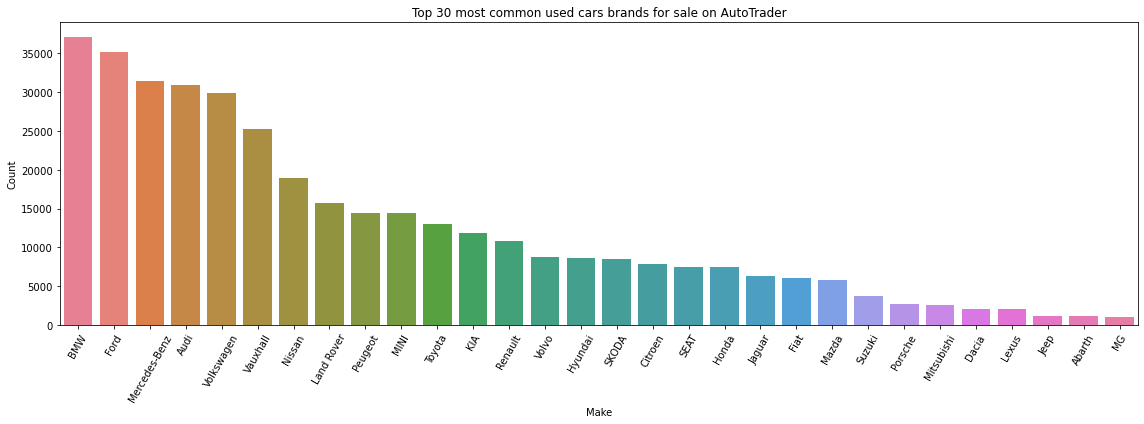

In [96]:
# Plot of make frequency 

df.groupby(by='make')['name'].count().sort_values(ascending=False).head(30).reset_index()

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,6))
sns.barplot(x="make", y="name", data=df.groupby(by='make')['name'].count().sort_values(ascending=False).head(30).reset_index()
            ,palette='husl').set_title('Top 30 most common used cars brands for sale on AutoTrader')
ax.set_xlabel('Make')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=60)
plt.tight_layout()
plt.savefig('carbrandcount.pdf',bbox_inches='tight')
plt.show()


*94% of cars can be described by the top 23 makes - should I drop the other 40? Tbc.*

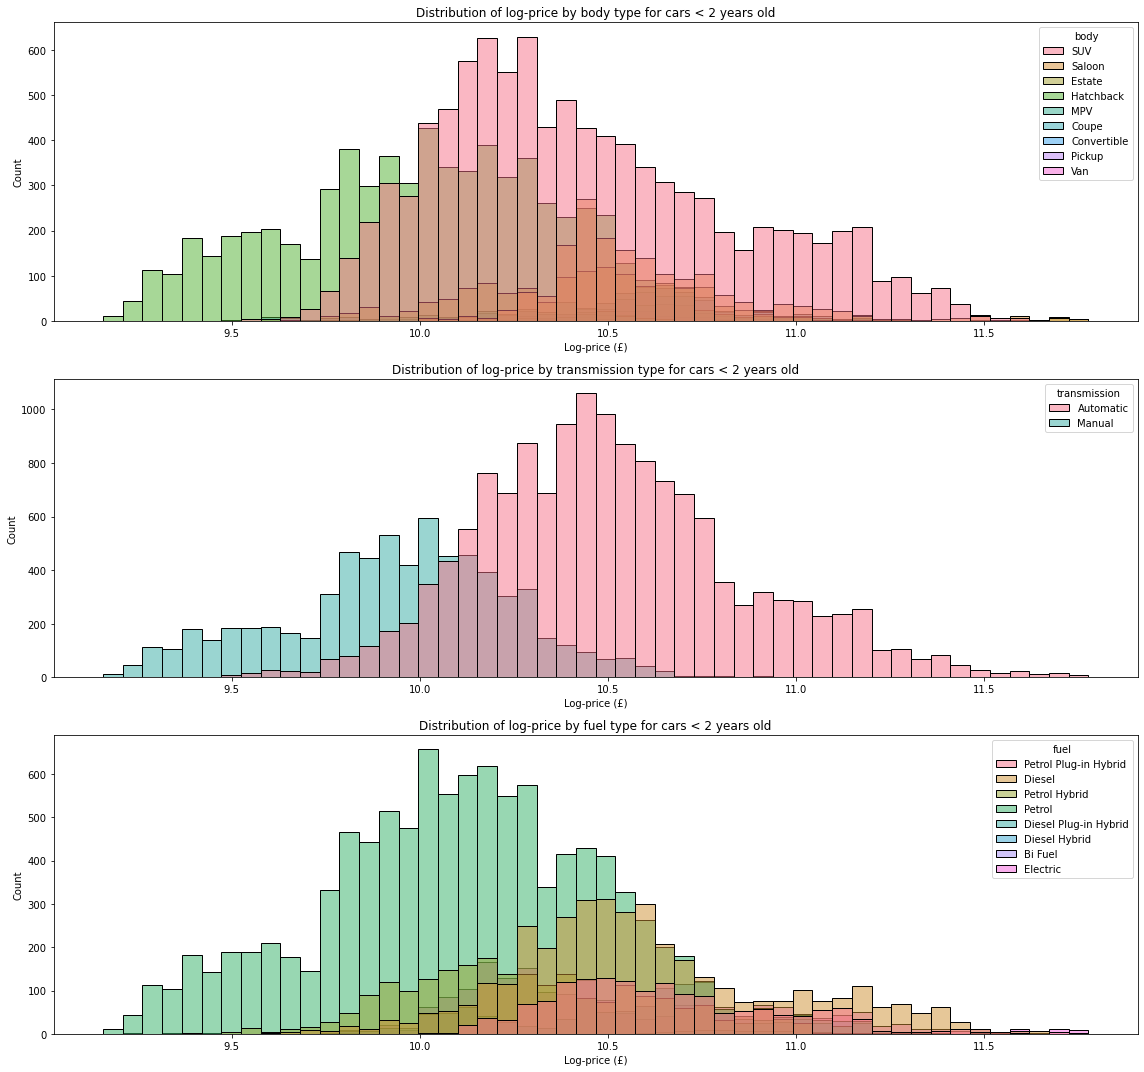

In [97]:
# Plot of pridce distributions by categorical variables - remove outliers first 

dfo=df.copy()
mask = np.abs((dfo.log_price - dfo.log_price.mean(0)) / dfo.log_price.std(0)) > 3
dfo= dfo[~mask]


fig, ax = plt.subplots(nrows=3, figsize=(16,15))
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="body",palette='husl',bins=50, legend=True, ax=ax[0]).set_title('Distribution of log-price by body type for cars < 2 years old')
ax[0].set_xlabel('Log-price (£)')
ax[0].set_ylabel('Count')
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="transmission",palette='husl',bins=50, legend=True, ax=ax[1]).set_title('Distribution of log-price by transmission type for cars < 2 years old')
ax[1].set_xlabel('Log-price (£)')
ax[1].set_ylabel('Count')
sns.histplot(data=dfo[dfo.year>2020], x="log_price",hue="fuel",palette='husl',bins=50, legend=True, ax=ax[2]).set_title('Distribution of log-price by fuel type for cars < 2 years old')
ax[2].set_xlabel('Log-price (£)')
ax[2].set_ylabel('Count')
plt.tight_layout()
plt.show()

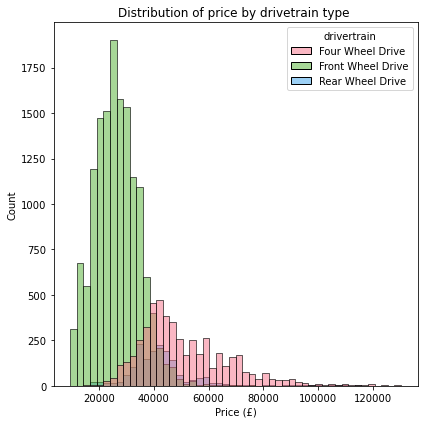

In [98]:
# Plot of pridce distributions by categorical variables - remove outliers first 

dfo=df.copy()
mask = np.abs((dfo.log_price - dfo.log_price.mean(0)) / dfo.log_price.std(0)) > 3
dfo= dfo[~mask]
dfo['drivetrain']=dfo.drivertrain


fig, ax = plt.subplots(figsize=(6,6))
sns.histplot(data=dfo[dfo.year>2020], x="price",hue="drivertrain",palette='husl',bins=50, legend=True, ax=ax).set_title('Distribution of price by drivetrain type ')
ax.set_xlabel('Price (£)')
ax.set_ylabel('Count')

plt.tight_layout()
plt.savefig('drivetraindist.pdf',bbox_inches='tight')

plt.show()

*In these three categorical variables presented it looks like transmission variable provides the best information on car price. Automatic cars are clearly more expensive than manual cars.*

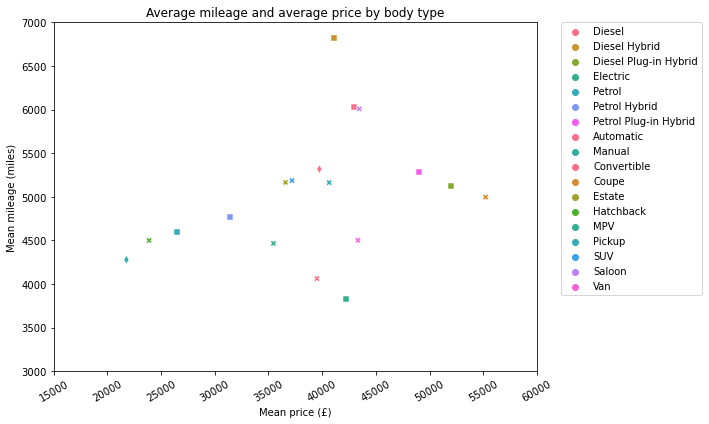

In [99]:
# Plot of avergae price and mileage figures for categorical variables - Failed 

plotdf1 = df[df.year>2020].groupby(by='fuel')[['price','mileage']].mean().reset_index()
plotdf1 = plotdf1[plotdf1.fuel!='Bi Fuel']
plotdf2 = df[df.year>2020].groupby(by='transmission')[['price','mileage']].mean().reset_index()
plotdf3 = df[df.year>2020].groupby(by='body')[['price','mileage']].mean().reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=plotdf1, x="price", y="mileage", hue="fuel",palette='husl', marker='s').set_title('Average mileage and average price by fuel type')
sns.scatterplot(data=plotdf2, x="price", y="mileage", hue="transmission",palette='husl', marker='d').set_title('Average mileage and average price by transmission type')
sns.scatterplot(data=plotdf3, x="price", y="mileage", hue="body",palette='husl', marker='X').set_title('Average mileage and average price by body type')
ax.set_xlabel('Mean price (£)')
ax.set_ylabel('Mean mileage (miles)')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim(3000,7000)
ax.set_xlim(15000,60000)
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

*This plot hasn't really worked - I wanted to get the shape of the marker in the legend but no luck. The plots below are broken up and detail it better.*

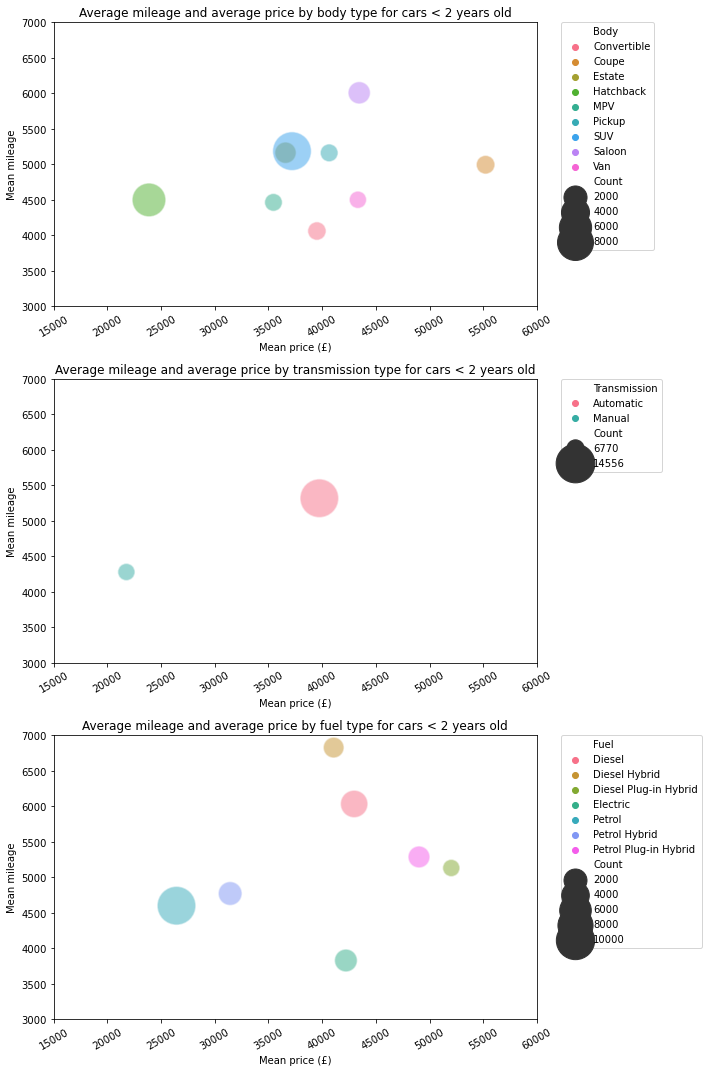

In [100]:
# Plot of avergae price and mileage figures for categorical variables

plotdf1 = df[df.year>2020].groupby(by='fuel')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf1 = plotdf1[plotdf1.fuel!='Bi Fuel']
plotdf1.columns = ['Fuel','price','mileage','Count']
plotdf2 = df[df.year>2020].groupby(by='transmission')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf2.columns = ['Transmission','price','mileage','Count']

plotdf3 = df[df.year>2020].groupby(by='body')[['price','mileage','doors']].agg({'price':'mean', 'mileage':'mean','doors':'count'}).reset_index()
plotdf3.columns = ['Body','price','mileage','Count']

fig, ax = plt.subplots(nrows=3,figsize=(10,15))
sns.scatterplot(data=plotdf1, x="price", y="mileage", hue="Fuel", size='Count',
                sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[2], 
                ).set_title('Average mileage and average price by fuel type for cars < 2 years old')
ax[2].set_xlabel('Mean price (£)')
ax[2].set_ylabel('Mean mileage')
sns.scatterplot(data=plotdf2, x="price", y="mileage", hue="Transmission",
                size='Count',sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[1], 
                ).set_title('Average mileage and average price by transmission type for cars < 2 years old')
ax[1].set_xlabel('Mean price (£)')
ax[1].set_ylabel('Mean mileage')
sns.scatterplot(data=plotdf3, x="price", y="mileage", hue="Body",size='Count',
                sizes=(300, 1500), alpha=.5,palette='husl', ax=ax[0], 
                ).set_title('Average mileage and average price by body type for cars < 2 years old')
ax[0].set_xlabel('Mean price (£)')
ax[0].set_ylabel('Mean mileage')
for i in range(0,3):
    ax[i].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax[i].set_ylim(3000,7000)
    ax[i].set_xlim(15000,60000)
    ax[i].tick_params(axis='x', rotation=30)   
plt.tight_layout()
plt.show()

*I don't really like these plots much. I was trying to show where the average car in each of these categories lies in terms of price and mileage. I'm not sure if I should filter based on year or not.*

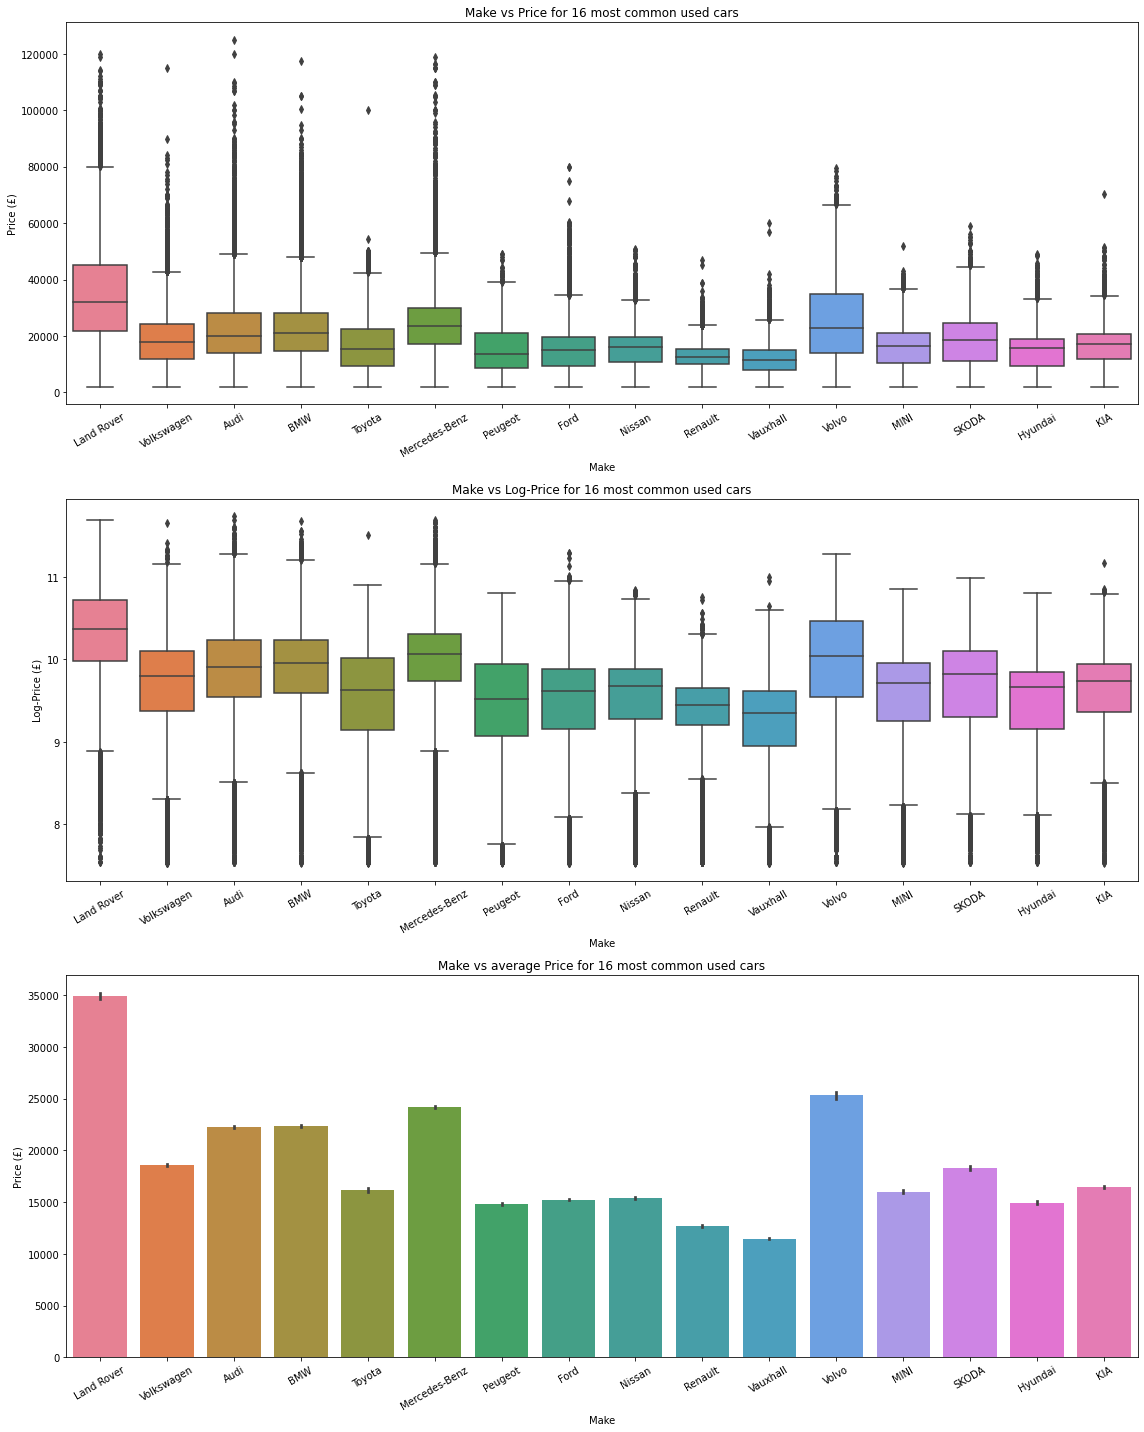

In [101]:
# Plot top 16 car brands - outliers removed in log-space
top15makes = list(df.make.value_counts().head(16).reset_index()['index'])
plotdf1 = df[df.make.isin(top15makes)]
# Remove outliers from log_price data - check this
mask = np.abs((plotdf1.log_price - plotdf1.log_price.mean(0)) / plotdf1.log_price.std(0)) > 3
plotdf1= plotdf1[~mask]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(16,20))
sns.boxplot(x='make', y='price', data=plotdf1, ax=ax[0],palette='husl').set_title('Make vs Price for 16 most common used cars')
ax[0].set_xlabel('Make')
ax[0].set_ylabel('Price (£)')
sns.boxplot(x='make', y='log_price', data=plotdf1,ax=ax[1],palette='husl').set_title('Make vs Log-Price for 16 most common used cars')
ax[1].set_xlabel('Make')
ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="make", y="price", data=plotdf1, ax=ax[2],palette='husl').set_title('Make vs average Price for 16 most common used cars')
ax[2].set_xlabel('Make')
ax[2].set_ylabel('Price (£)')
for i in range(0,3):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

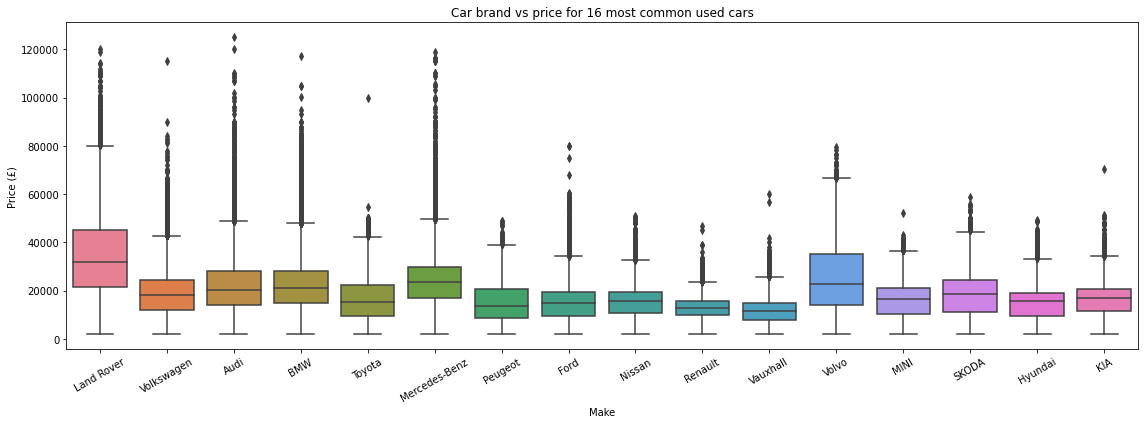

In [102]:
# Plot top 16 car brands - outliers removed in log-space
top15makes = list(df.make.value_counts().head(16).reset_index()['index'])
plotdf1 = df[df.make.isin(top15makes)]
# Remove outliers from log_price data - check this
mask = np.abs((plotdf1.log_price - plotdf1.log_price.mean(0)) / plotdf1.log_price.std(0)) > 3
plotdf1= plotdf1[~mask]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,6))
sns.boxplot(x='make', y='price', data=plotdf1, ax=ax,palette='husl').set_title('Car brand vs price for 16 most common used cars')
ax.set_xlabel('Make')
ax.set_ylabel('Price (£)')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig('branddist.pdf',bbox_inches='tight')

plt.show()

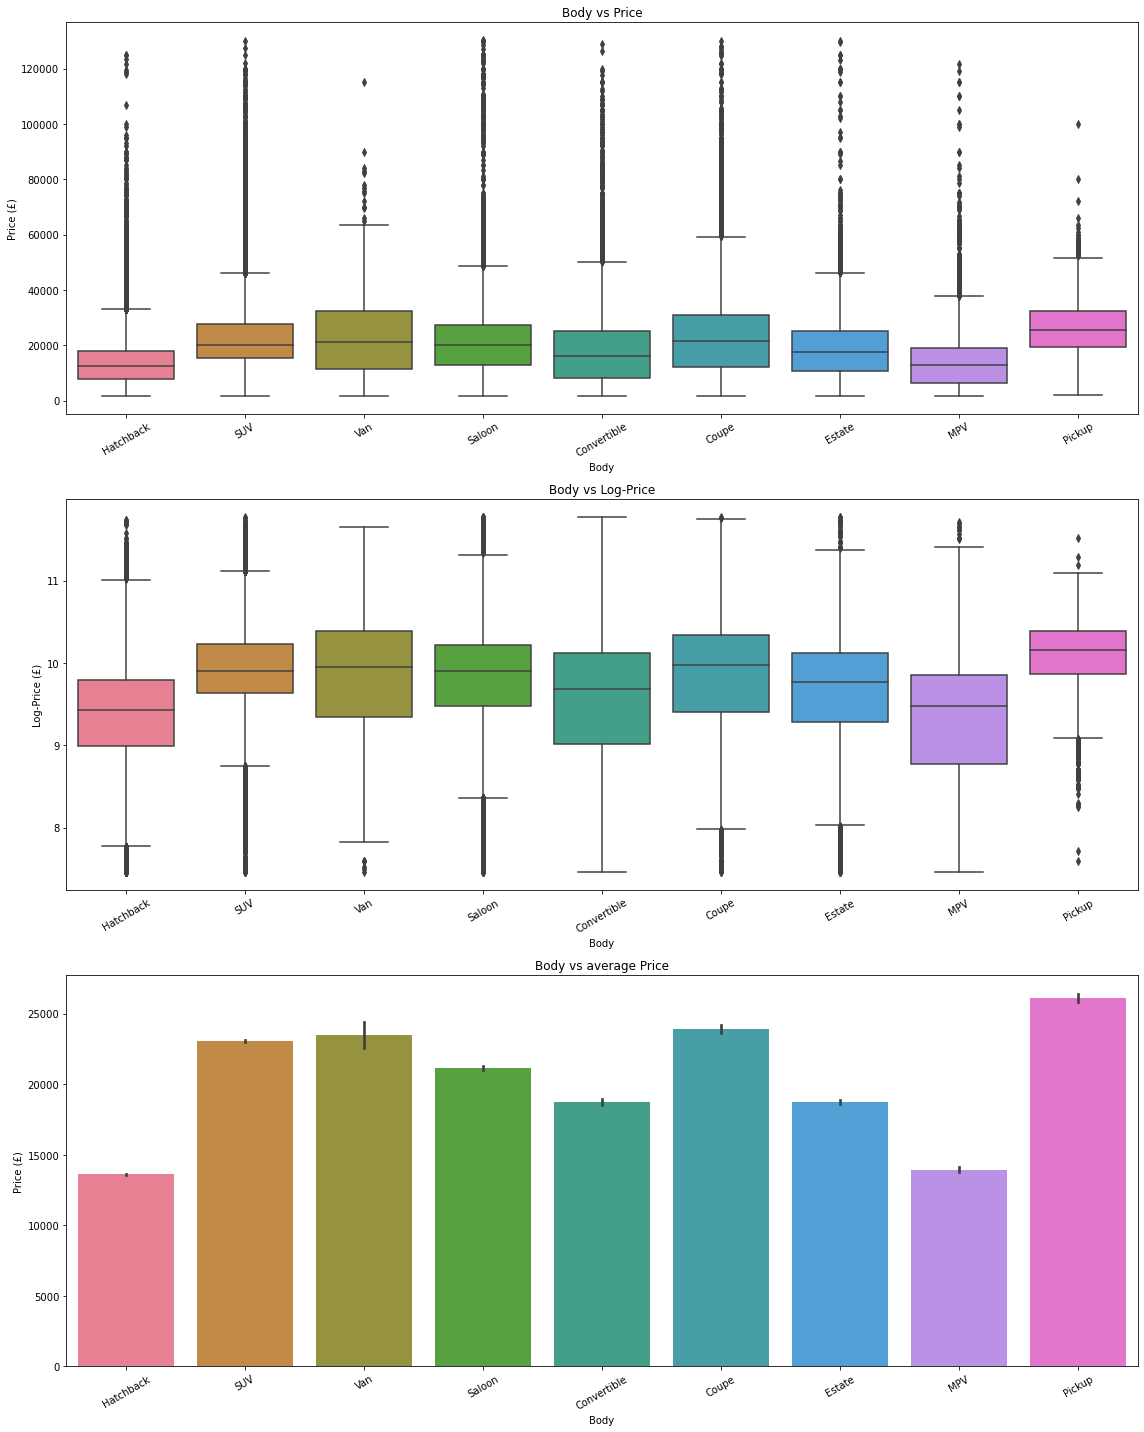

In [103]:
# Plot by body type - outliers removed in log-space

# Remove outliers from log_price data - check this
mask = np.abs((df.log_price - df.log_price.mean(0)) / df.log_price.std(0)) > 3
plotdf2= df[~mask]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(16,20))
sns.color_palette("husl", 8)
sns.boxplot(x='body', y='price', data=plotdf2, ax=ax[0], palette='husl').set_title('Body vs Price')
ax[0].set_xlabel('Body')
ax[0].set_ylabel('Price (£)')
sns.boxplot(x='body', y='log_price', data=plotdf2,ax=ax[1],palette='husl').set_title('Body vs Log-Price')
ax[1].set_xlabel('Body')
ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="body", y="price", data=plotdf2, ax=ax[2],palette='husl').set_title('Body vs average Price')
ax[2].set_xlabel('Body')
ax[2].set_ylabel('Price (£)')
for i in range(0,3):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

In [104]:
# Checking outlier code
f= df[df.year==2013].sort_values(by='log_price',ascending=False).head(1)
for index, car in f.iterrows():
    print(car)
    print(car[-2])

name                                                       porsche 911
name_subtitle           3.8 991 50th Anniversary Edition PDK (s/s) 2dr
year                                                              2013
price                                                         119500.0
body                                                             Coupe
mileage                                                         9685.0
BHP                                                         394.477318
doors                                                              2dr
transmission                                                 Automatic
make                                                           Porsche
fuel                                                            Petrol
mpg                                                            OVER_30
drivertrain                                           Rear Wheel Drive
engine                                                             3.8
owners

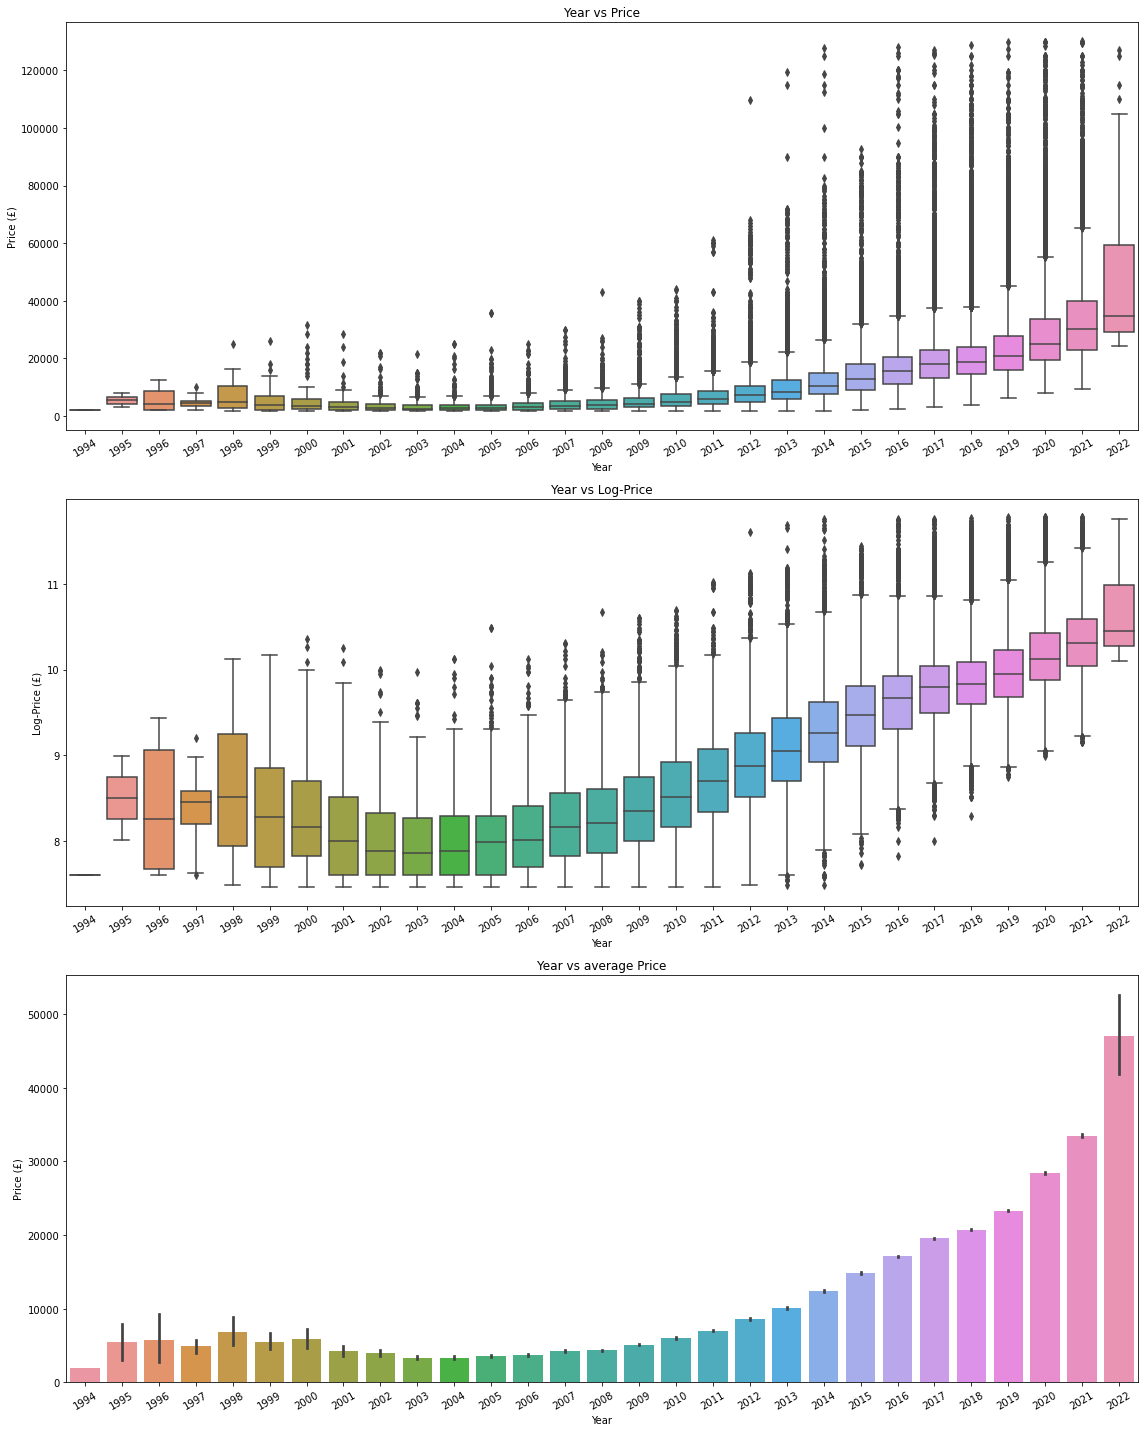

In [105]:
# Plot by year - outliers removed in log-space 

# Remove outliers from log_price data - check this
mask = np.abs((df.log_price - df.log_price.mean(0)) / df.log_price.std(0)) > 3
plotdf2= df[~mask]

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(16,20))
sns.boxplot(x='year', y='price', data=plotdf2, ax=ax[0]).set_title('Year vs Price')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Price (£)')
sns.boxplot(x='year', y='log_price', data=plotdf2,ax=ax[1]).set_title('Year vs Log-Price')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Log-Price (£)')
sns.barplot(x="year", y="price", data=plotdf2, ax=ax[2]).set_title('Year vs average Price')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Price (£)')
for i in range(0,3):
    ax[i].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

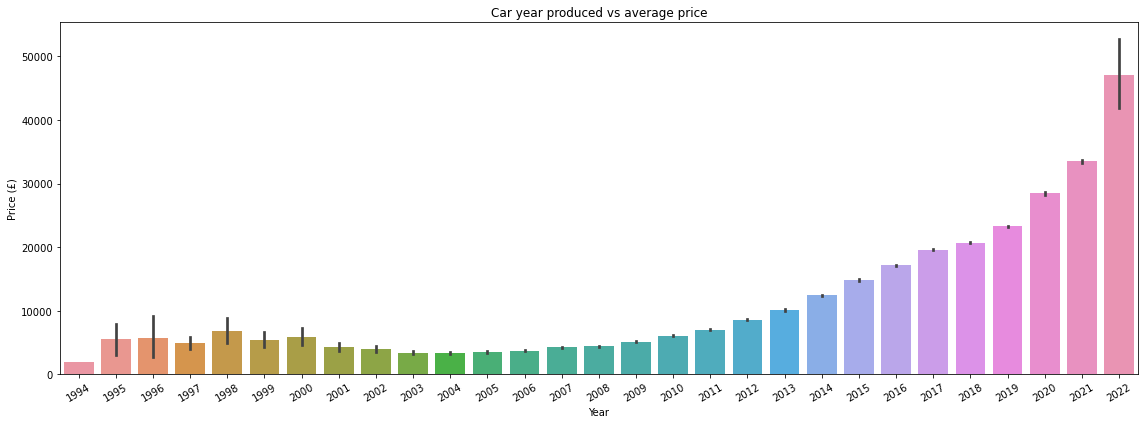

In [106]:
# Plot by year - outliers removed in log-space 

# Remove outliers from log_price data - check this
mask = np.abs((df.log_price - df.log_price.mean(0)) / df.log_price.std(0)) > 3
plotdf2= df[~mask]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,6))
sns.barplot(x="year", y="price", data=plotdf2, ax=ax).set_title('Car year produced vs average price')
ax.set_xlabel('Year')
ax.set_ylabel('Price (£)')
ax.tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.savefig('yearprice.pdf',bbox_inches='tight')
plt.show()

In [107]:
plotdf2[plotdf2['drivertrain']=='Rear Wheel Drive'].name.value_counts().head(20)

bmw 3 series             6091
bmw 1 series             5676
mercedes-benz c class    5435
bmw 5 series             3131
mercedes-benz e class    3056
bmw 4 series             3023
bmw 2 series             2008
jaguar xf                1635
mazda mx-5               1438
mercedes-benz c-class    1346
jaguar xe                1060
mercedes-benz slk         771
bmw z4                    736
mercedes-benz e-class     686
smart fortwo              631
bmw 6 series              547
mercedes-benz sl          535
mercedes-benz s class     433
jaguar f-type             424
bmw m4                    415
Name: name, dtype: int64

*These plots help describe the relationship between price and age of a car. It can be seen to decease as the car year approaches 2003, before a slight increase in average price. This must be the vintage car factor being introduced. Note that confidence bounds are wider for newer cars and older cars as the sample size within each year is greatly reduced.*

## Distribution and collinearity evaluation

In [108]:
# Import packages 
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

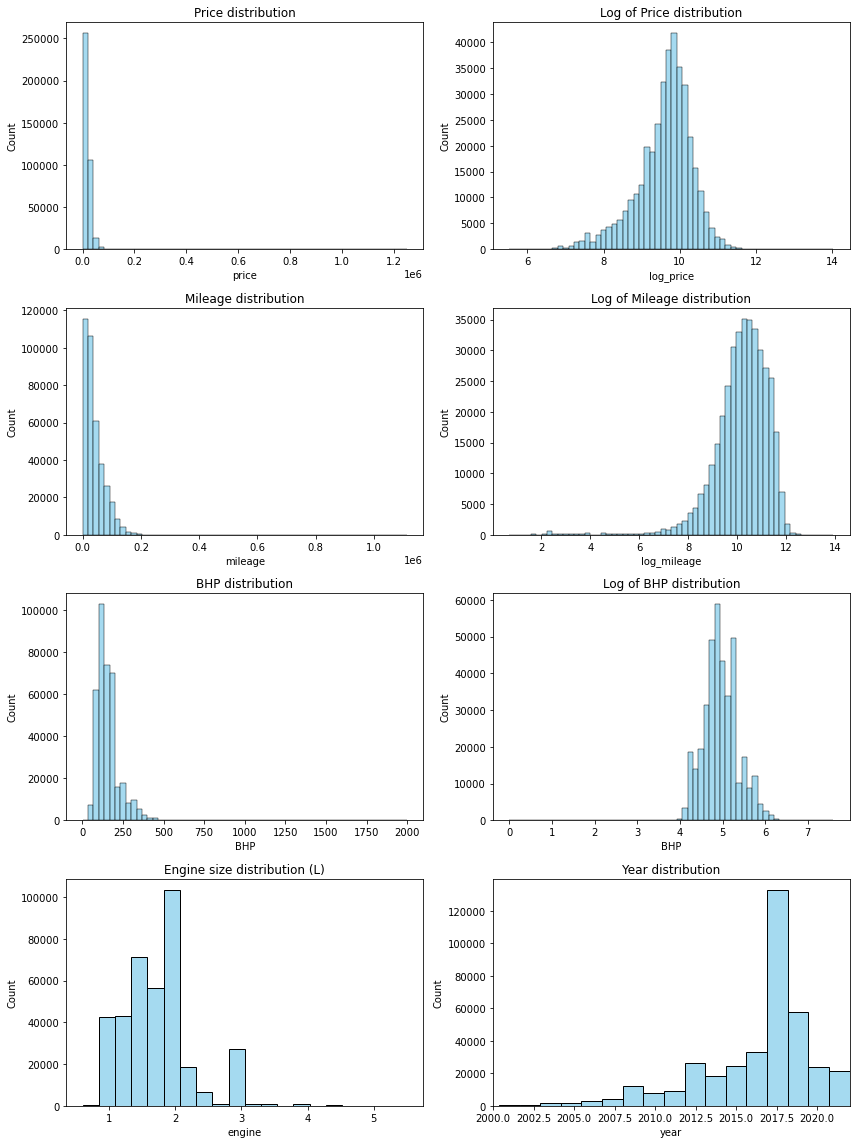

In [109]:
# Seaborn plots of continuous variables

# plt.style.use('ggplot')

# %config InlineBackend.figure_format = 'retina'
# %matplotlib inline



fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
sns.histplot(data=df.price, bins=60, color='skyblue',ax=ax[0,0]).set_title('Price distribution')
sns.histplot(data=df.log_price, bins=60, color='skyblue',ax=ax[0,1]).set_title('Log of Price distribution')
sns.histplot(data=df.mileage, bins=60, color='skyblue',ax=ax[1,0]).set_title('Mileage distribution')
sns.histplot(data=df.log_mileage, bins=60, color='skyblue',ax=ax[1,1]).set_title('Log of Mileage distribution')
sns.histplot(data=df.BHP, bins=60, color='skyblue',ax=ax[2,0]).set_title('BHP distribution')
sns.histplot(data=df.BHP.apply(lambda x: np.log(x)), bins=60, color='skyblue',ax=ax[2,1]).set_title('Log of BHP distribution')
sns.histplot(data=df.engine, bins=20, color='skyblue',ax=ax[3,0]).set_title('Engine size distribution (L)')
sns.histplot(data=df.year, bins=22, color='skyblue',ax=ax[3,1]).set_title('Year distribution')
ax[3,1].set_xlim(2000,2022)
plt.tight_layout()
plt.show()

/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/2928868623.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfplot= dfplot[~mask]
/var/folders/1h/l422441d07d4l2q1nfyrjk740000gn/T/ipykernel_18360/2928868623.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfplot= dfplot[~mask]


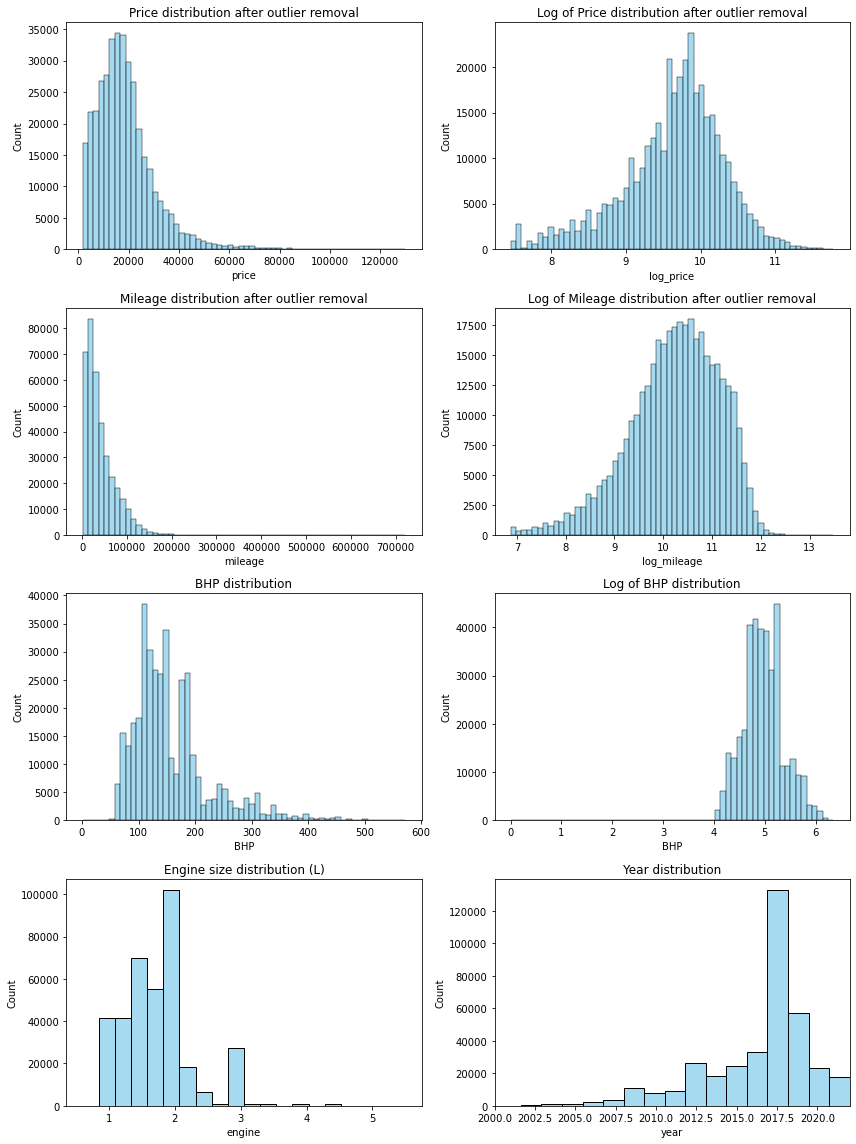

In [110]:
mask = np.abs((df.log_price - df.log_price.mean()) / df.log_price.std()) > 3
dfplot= df[~mask]

mask = np.abs((df.log_mileage - df.log_mileage.mean()) / df.log_mileage.std()) > 3
dfplot= dfplot[~mask]

mask = np.abs((df.BHP - df.BHP.mean()) / df.BHP.std()) > 6
dfplot= dfplot[~mask]

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,16))
sns.histplot(data=dfplot.price, bins=60, color='skyblue',ax=ax[0,0]).set_title('Price distribution after outlier removal')
sns.histplot(data=dfplot.log_price, bins=60, color='skyblue',ax=ax[0,1]).set_title('Log of Price distribution after outlier removal')
sns.histplot(data=dfplot.mileage, bins=60, color='skyblue',ax=ax[1,0]).set_title('Mileage distribution after outlier removal')
sns.histplot(data=dfplot.log_mileage, bins=60, color='skyblue',ax=ax[1,1]).set_title('Log of Mileage distribution after outlier removal')
sns.histplot(data=dfplot.BHP, bins=60, color='skyblue',ax=ax[2,0]).set_title('BHP distribution')
sns.histplot(data=dfplot.BHP.apply(lambda x: np.log(x)), bins=60, color='skyblue',ax=ax[2,1]).set_title('Log of BHP distribution')
sns.histplot(data=dfplot.engine, bins=20, color='skyblue',ax=ax[3,0]).set_title('Engine size distribution (L)')
sns.histplot(data=dfplot.year, bins=22, color='skyblue',ax=ax[3,1]).set_title('Year distribution')
ax[3,1].set_xlim(2000,2022)
plt.tight_layout()
plt.show()

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378597 entries, 0 to 400246
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   name               378597 non-null  object 
 1   name_subtitle      378597 non-null  object 
 2   year               378597 non-null  int64  
 3   price              378597 non-null  float64
 4   body               378597 non-null  object 
 5   mileage            378597 non-null  float64
 6   BHP                378597 non-null  float64
 7   doors              378597 non-null  object 
 8   transmission       378597 non-null  object 
 9   make               378597 non-null  object 
 10  fuel               378597 non-null  object 
 11  mpg                378597 non-null  object 
 12  drivertrain        378597 non-null  object 
 13  engine             373857 non-null  float64
 14  owners             196683 non-null  float64
 15  ULEZ               330546 non-null  object 
 16  co

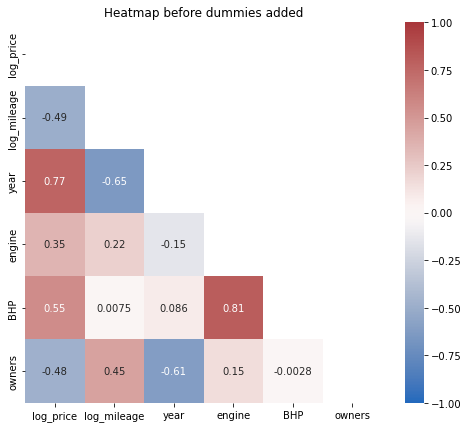

In [112]:
# Heatmap before dummies

tocorr=['log_price','log_mileage','year','engine','BHP','owners']
plt.rcParams["figure.figsize"] = (8,7)
mask =np.zeros_like(df[tocorr].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df[tocorr].corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, mask=mask)
plt.title('Heatmap before dummies added')
plt.show()

*Looks like there's some significant correlation between engine and BHP. I don't want to use highly correlated predictors so I'm going to have to drop one - Engine. This is fortunate actually because engine units are inconsistent between electric cars and conventional cars. I will drop the engine column.*

In [113]:
#Checking for null values 
df[tocorr].isnull().sum()

log_price           0
log_mileage         0
year                0
engine           4740
BHP                 0
owners         181914
dtype: int64

*As well as dropping the engine column, I'm going to have to drop the owners column. This just wasn't populated enough on AutoTrader and has 45% NaN values.*

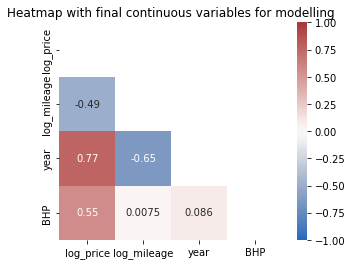

In [114]:
# Heatmap after dropping engine and owners

tocorr=['log_price','log_mileage','year','BHP']
plt.rcParams["figure.figsize"] = (5,4)
mask =np.zeros_like(df[tocorr].corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df[tocorr].corr(), vmin=-1, vmax=1, cmap='vlag', annot=True, mask=mask)
plt.title('Heatmap with final continuous variables for modelling')
plt.show()

In [115]:
# Modelling without dummies  - assess VIF 

# Define X and y
X = df[['log_mileage','year','BHP']]

# Great link on multicollinearity
# https://blog.minitab.com/en/understanding-statistics/handling-multicollinearity-in-regression-analysis

# If VIF=1 then there's no multicollinearity
# If VIF>5 then there's significant multicollinearity and it will be a problem

Xvif = add_constant(X)
VIF = pd.Series([variance_inflation_factor(Xvif.values, i) 
               for i in range(Xvif.shape[1])], 
              index=Xvif.columns)
print('VIF stats: \n',VIF,'\n')

VIF stats: 
 const          585106.407329
log_mileage         1.733253
year                1.745943
BHP                 1.014329
dtype: float64 



*The remaining continuous variables are not overly correlated. This bodes well for model building.*

In [116]:
import scipy.stats as stats
import itertools

In [117]:
# Chi2 stats for categorical variables
results=[]
categoricals = ['mpg','drivertrain','make','body','transmission','fuel','doors']
for x in itertools.combinations(('mpg','drivertrain','make','body','transmission','fuel','doors'), 2):
    categoricalv1 = x[0]
    categoricalv2 = x[1]
    cross_tab = pd.crosstab(df[categoricalv1], df[categoricalv2])
    chi2 = stats.chi2_contingency(cross_tab)
    results.append([x[0],x[1],chi2[0],round(chi2[1],4),chi2[2]])
    chi2df = pd.DataFrame(results, columns = ['categorical1','categorical2','chi2_statistic','p-value','degrees_of_freedom'])

chi2df

,categorical1,categorical2,chi2_statistic,p-value,degrees_of_freedom
0,mpg,drivertrain,59133.052007,0.0,8
1,mpg,make,112047.440184,0.0,244
2,mpg,body,52307.652912,0.0,32
3,mpg,transmission,30496.731096,0.0,4
4,mpg,fuel,437714.790195,0.0,28
5,mpg,doors,10709.258978,0.0,16
6,drivertrain,make,300835.738416,0.0,122
7,drivertrain,body,213637.570940,0.0,16
8,drivertrain,transmission,94247.039532,0.0,2
9,drivertrain,fuel,57479.628980,0.0,14


In [118]:
# I NEED TO FIND A STATISTICAL REASON TO NOT USE THE MPG VARIABLE

In [119]:
df.groupby('mpg')['BHP'].count().reset_index()

,mpg,BHP
0,Electric,4740
1,OVER_30,70561
2,OVER_40,130183
3,OVER_50,98247
4,OVER_60,74866


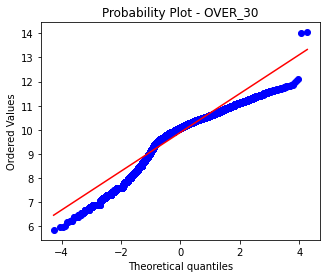

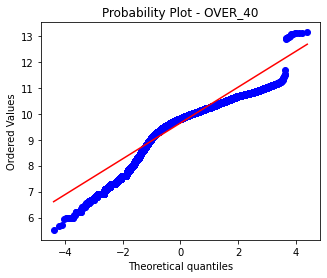

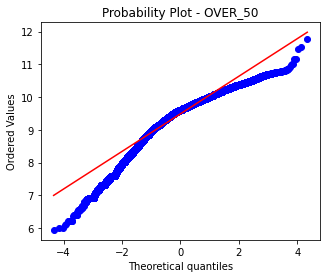

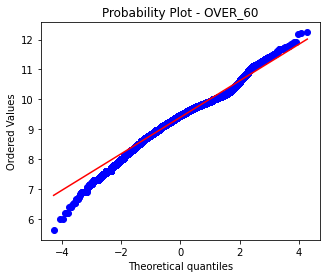

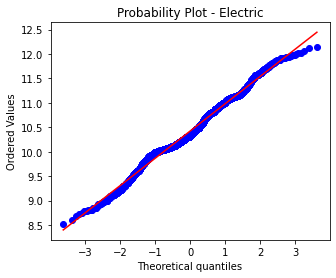

In [120]:
# PLOTS OF DISTRIBUTION FOR MPG variable

import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt

unique_mpg = df['mpg'].unique()
for mpg in unique_mpg:
    stats.probplot(df[df['mpg'] == mpg]['log_price'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  mpg)
    plt.show()

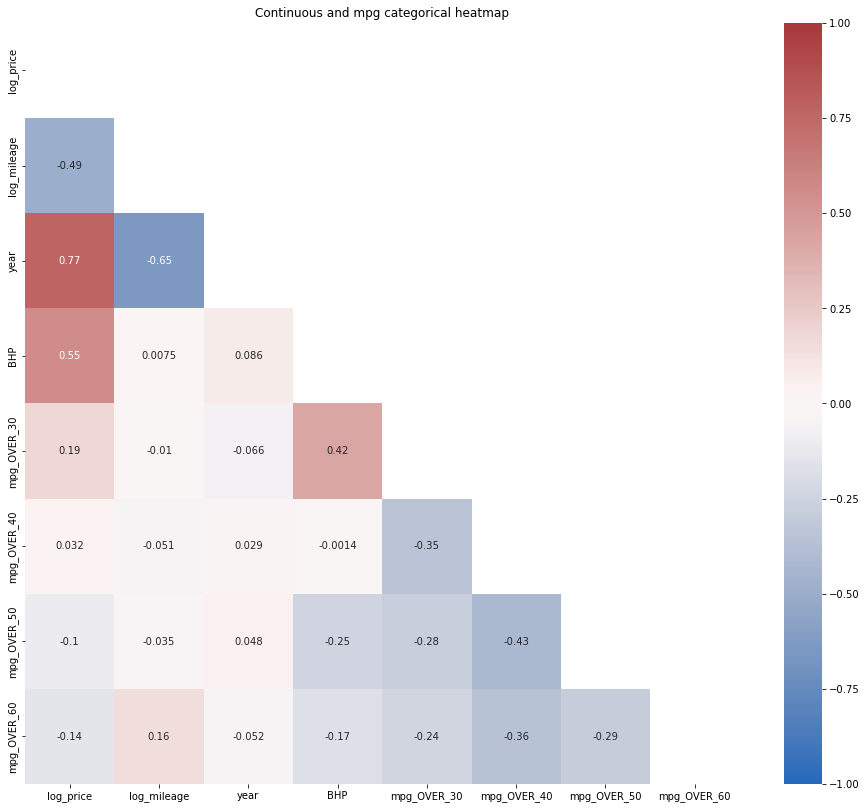

In [121]:
# Heatmap after dummies - choose the categorical  
to_dummy=['mpg','drivertrain','make','body','transmission','fuel','doors']

categorical = 'mpg'

X = df[['log_price','log_mileage','year','BHP',categorical]]
to_dummy=[categorical]
X= pd.get_dummies(X, columns = to_dummy, drop_first=True)

plt.rcParams["figure.figsize"] = (16,14)
mask =np.zeros_like(X.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X.corr(), vmin=-1, vmax=1, cmap='vlag', mask=mask, annot=True)
plt.title(f'Continuous and {categorical} categorical heatmap')
plt.show()